# Income Estimator - Exploratory Data Analysis

This notebook demonstrates exploratory data analysis for the income estimation project.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

%matplotlib inline

## 1. Load Data

In [2]:
# =============================================================================
# STEP 1: INITIAL DATA LOADING AND INSPECTION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Load the datasets
print("Loading datasets...")
df_clientes = pd.read_csv(r'C:\Users\david\OneDrive\Documents\augment-projects\caja-social\income-estimator-ml\data\raw\Info_Cliente.csv', 
                         encoding='latin-1', sep=';', on_bad_lines='skip', engine='python')
df_apc = pd.read_csv(r'C:\Users\david\OneDrive\Documents\augment-projects\caja-social\income-estimator-ml\data\raw\Info_APC.csv', 
                     encoding='latin-1', sep=';', on_bad_lines='skip', engine='python')

print(f"✅ Clientes dataset loaded: {df_clientes.shape}")
print(f"✅ APC dataset loaded: {df_apc.shape}")

Loading datasets...
✅ Clientes dataset loaded: (19047, 19)
✅ APC dataset loaded: (32170, 11)


## Initial Data Inspection

In [3]:
# =============================================================================
# STEP 2: INITIAL DATA INSPECTION
# =============================================================================

def inspect_dataset(df, name):
    """
    Perform initial inspection of a dataset
    """
    print(f"\n{'='*60}")
    print(f"DATASET INSPECTION: {name}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Column info
    print(f"\nColumn Information:")
    print(f"Total columns: {len(df.columns)}")
    
    # Data types
    print(f"\nData Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Missing values
    missing_info = df.isnull().sum()
    missing_pct = (missing_info / len(df) * 100).round(2)
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_info,
        'Missing_Percentage': missing_pct
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    if len(missing_summary) > 0:
        print(f"\nMissing Values (Top 10):")
        print(missing_summary.head(10))
    else:
        print(f"\n✅ No missing values found!")
    
    # Sample data
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    return missing_summary

# Inspect both datasets
clientes_missing = inspect_dataset(df_clientes, "CLIENTES")
apc_missing = inspect_dataset(df_apc, "APC")


DATASET INSPECTION: CLIENTES
Shape: (19047, 19)
Memory usage: 18.19 MB

Column Information:
Total columns: 19

Data Types:
  object: 13 columns
  int64: 3 columns
  float64: 3 columns

Missing Values (Top 10):
                        Missing_Count  Missing_Percentage
monto_letra                      3396               17.83
fecha_vencimiento                3388               17.79
CargoEmpleoCliente               2036               10.69
FechaIngresoEmpleo                893                4.69
NombreEmpleadorCliente            536                2.81
Ciudad                            217                1.14
Ocupacion                           2                0.01

First 3 rows:
   Cliente Identificador_Unico Segmento  Edad       Sexo  \
0     3642           9-706-693     D34Z    47  Masculino   
1    10547           8-904-143     D02Z    29   Femenino   
2    13095           8-398-877     C66Q    74  Masculino   

                                          Ciudad  \
0  ANTON         

In [4]:
# =============================================================================
# STEP 3: COLUMN NAME STANDARDIZATION (CORRECTED)
# =============================================================================

def standardize_column_names(df, dataset_name):
    """
    Standardize column names by:
    1. Converting to lowercase
    2. Replacing spaces and special characters with underscores
    3. Removing accents and special characters
    4. Ensuring names are Python-friendly
    5. Fixing specific problematic columns
    """
    print(f"\n🔧 Standardizing column names for {dataset_name}...")
    
    original_columns = df.columns.tolist()
    
    # Function to clean individual column names
    def clean_column_name(col_name):
        # Convert to string and lowercase
        clean_name = str(col_name).lower()
        
        # Fix specific problematic columns
        if 'ï»¿identificador_unico' in clean_name or 'identificador_unico' in clean_name:
            return 'identificador_unico'
        
        # Replace common Spanish characters
        replacements = {
            'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u',
            'ñ': 'n', 'ç': 'c'
        }
        for old, new in replacements.items():
            clean_name = clean_name.replace(old, new)
        
        # Remove BOM and other special characters
        clean_name = clean_name.replace('\ufeff', '')  # Remove BOM
        clean_name = clean_name.replace('ï»¿', '')     # Remove BOM variants
        
        # Replace spaces, dots, and special characters with underscores
        clean_name = re.sub(r'[^\w]', '_', clean_name)
        
        # Remove multiple consecutive underscores
        clean_name = re.sub(r'_+', '_', clean_name)
        
        # Remove leading/trailing underscores
        clean_name = clean_name.strip('_')
        
        # Ensure it doesn't start with a number
        if clean_name and clean_name[0].isdigit():
            clean_name = 'col_' + clean_name
            
        return clean_name
    
    # Apply cleaning to all columns
    new_columns = [clean_column_name(col) for col in original_columns]
    
    # Create mapping for reference
    column_mapping = pd.DataFrame({
        'Original': original_columns,
        'Standardized': new_columns
    })
    
    # Apply new column names
    df.columns = new_columns
    
    print(f"✅ Column names standardized!")
    print(f"📋 Column mapping:")
    for i, (orig, new) in enumerate(zip(original_columns, new_columns)):
        if orig != new:
            print(f"  '{orig}' → '{new}'")
    
    return df, column_mapping

# Standardize column names for both datasets
df_clientes, clientes_mapping = standardize_column_names(df_clientes, "CLIENTES")
df_apc, apc_mapping = standardize_column_names(df_apc, "APC")

# Display new column names
print(f"\n📊 CLIENTES columns ({len(df_clientes.columns)}): {list(df_clientes.columns)}")
print(f"\n📊 APC columns ({len(df_apc.columns)}): {list(df_apc.columns)}")


🔧 Standardizing column names for CLIENTES...
✅ Column names standardized!
📋 Column mapping:
  'Cliente' → 'cliente'
  'Identificador_Unico' → 'identificador_unico'
  'Segmento' → 'segmento'
  'Edad' → 'edad'
  'Sexo' → 'sexo'
  'Ciudad' → 'ciudad'
  'Pais' → 'pais'
  'Ocupacion' → 'ocupacion'
  'Estado_Civil' → 'estado_civil'
  'FechaIngresoEmpleo' → 'fechaingresoempleo'
  'NombreEmpleadorCliente' → 'nombreempleadorcliente'
  'CargoEmpleoCliente' → 'cargoempleocliente'

🔧 Standardizing column names for APC...
✅ Column names standardized!
📋 Column mapping:
  'ï»¿identificador_unico' → 'identificador_unico'
  'Codigo_Secuencial' → 'codigo_secuencial'

📊 CLIENTES columns (19): ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados']

📊 APC colu

In [5]:
# =============================================================================
# STEP 4: DATE COLUMN IDENTIFICATION AND CONVERSION (CORRECTED)
# =============================================================================

def identify_specific_date_columns(df, dataset_name):
    """
    Identify specific date columns based on your requirements:
    - df_clientes: 'fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento'
    - df_apc: 'fecha_inicio', 'dg_fechaconsulta'
    """
    print(f"\n📅 Identifying specific date columns in {dataset_name}...")
    
    if dataset_name == "CLIENTES":
        # Specific date columns for clientes dataset
        target_date_cols = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
    elif dataset_name == "APC":
        # Specific date columns for APC dataset
        target_date_cols = ['fecha_inicio', 'dg_fechaconsulta']
    else:
        target_date_cols = []
    
    # Find which of these columns actually exist in the dataset
    existing_date_cols = []
    for col in target_date_cols:
        if col in df.columns:
            existing_date_cols.append(col)
        else:
            print(f"⚠️  Expected date column '{col}' not found in {dataset_name}")
    
    print(f"🔍 Date columns found in {dataset_name}: {existing_date_cols}")
    
    # Show sample values for each date column
    for col in existing_date_cols:
        sample_vals = df[col].dropna().head(5).tolist()
        data_type = df[col].dtype
        print(f"  {col} ({data_type}): {sample_vals}")
    
    return existing_date_cols

def convert_date_columns_fixed(df, date_columns, dataset_name):
    """
    Convert date columns with proper DD/MM/YYYY format handling
    FIXED VERSION: Uses correct format specification for 100% success rate
    """
    print(f"\n🔄 Converting date columns in {dataset_name} (FIXED VERSION)...")
    
    conversion_log = []
    
    for col in date_columns:
        if col not in df.columns:
            print(f"  ⚠️  Column {col} not found")
            continue
            
        original_dtype = df[col].dtype
        non_null_count = df[col].notna().sum()
        original_sample = df[col].dropna().head(3).tolist()
        
        print(f"\n  Converting {col}...")
        print(f"    Original type: {original_dtype}")
        print(f"    Non-null values: {non_null_count:,}")
        print(f"    Sample values: {original_sample}")
        
        # Create backup
        backup_col = f"{col}_original"
        df[backup_col] = df[col].copy()
        
        try:
            conversion_method = ""
            
            # Strategy 1: For string dates in DD/MM/YYYY format (like '08/05/2018')
            if df[col].dtype == 'object':
                # Check if data contains slashes (DD/MM/YYYY format)
                sample_str = df[col].dropna().astype(str).head(10)
                if sample_str.str.contains('/', na=False).any():
                    # Use explicit DD/MM/YYYY format
                    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')
                    conversion_method = "DD/MM/YYYY format conversion"
                else:
                    # Try flexible conversion with dayfirst
                    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
                    conversion_method = "Flexible conversion with dayfirst=True"
            
            # Strategy 2: For numeric dates (like 8052018 = DDMMYYYY)
            elif df[col].dtype in ['int64', 'float64']:
                # Convert to string and try DDMMYYYY format
                date_strings = df[col].astype(str).str.replace('.0', '', regex=False)
                df[col] = pd.to_datetime(date_strings, format='%d%m%Y', errors='coerce')
                conversion_method = "Numeric DDMMYYYY format conversion"
            
            else:
                # Try flexible conversion as fallback
                df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
                conversion_method = "Flexible conversion with dayfirst=True"
            
            # Check success rate
            valid_dates = df[col].notna().sum()
            success_rate = valid_dates / non_null_count if non_null_count > 0 else 0
            
            print(f"    ✅ Conversion successful!")
            print(f"    Method: {conversion_method}")
            print(f"    Success rate: {success_rate:.1%} ({valid_dates:,}/{non_null_count:,})")
            
            # Show sample converted values
            if valid_dates > 0:
                sample_converted = df[col].dropna().head(3)
                print(f"    Sample results: {sample_converted.dt.strftime('%Y-%m-%d').tolist()}")
            
            conversion_log.append({
                'column': col,
                'method': conversion_method,
                'success_rate': success_rate,
                'converted_count': valid_dates
            })
            
            # Remove backup if conversion was very successful
            if success_rate > 0.95:
                df.drop(columns=[backup_col], inplace=True)
                print(f"    🗑️  Backup removed (high success rate)")
            else:
                print(f"    📋 Backup kept as {backup_col} (success rate: {success_rate:.1%})")
                
        except Exception as e:
            print(f"    ❌ Error converting {col}: {str(e)}")
            # Restore original if backup exists
            if backup_col in df.columns:
                df[col] = df[backup_col]
                df.drop(columns=[backup_col], inplace=True)
    
    return df, conversion_log

# Identify and convert date columns for both datasets with specific columns
clientes_date_cols = identify_specific_date_columns(df_clientes, "CLIENTES")
df_clientes, clientes_date_log = convert_date_columns_fixed(df_clientes, clientes_date_cols, "CLIENTES")

apc_date_cols = identify_specific_date_columns(df_apc, "APC")
df_apc, apc_date_log = convert_date_columns_fixed(df_apc, apc_date_cols, "APC")

# Verify target column is NOT treated as date
print(f"\n🎯 Verifying target column 'ingresos_reportados' in CLIENTES:")
if 'ingresos_reportados' in df_clientes.columns:
    target_dtype = df_clientes['ingresos_reportados'].dtype
    target_sample = df_clientes['ingresos_reportados'].dropna().head(5).tolist()
    print(f"   Type: {target_dtype}")
    print(f"   Sample values: {target_sample}")
    print(f"   ✅ Correctly preserved as numeric target variable")
else:
    print(f"   ⚠️  Target column 'ingresos_reportados' not found!")

# Verify conversion results
print(f"\n✅ CONVERSION VERIFICATION:")
print("="*50)

def verify_date_conversion(df, date_columns, dataset_name):
    """Verify that date conversion worked properly"""
    for col in date_columns:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            non_null_dates = df[col].dropna()
            print(f"📅 {dataset_name} - {col}:")
            print(f"   ✅ Successfully converted to datetime")
            print(f"   📊 Valid dates: {len(non_null_dates):,}")
            if len(non_null_dates) > 0:
                print(f"   📈 Date range: {non_null_dates.min().strftime('%Y-%m-%d')} to {non_null_dates.max().strftime('%Y-%m-%d')}")
        else:
            print(f"❌ {dataset_name} - {col}: Conversion failed or column missing")

verify_date_conversion(df_clientes, clientes_date_cols, "CLIENTES")
verify_date_conversion(df_apc, apc_date_cols, "APC")

print(f"\n🎉 DATE CONVERSION COMPLETED!")
print(f"Expected: ~100% success rate for DD/MM/YYYY string formats")
print(f"Expected: ~100% success rate for DDMMYYYY numeric formats")


📅 Identifying specific date columns in CLIENTES...
🔍 Date columns found in CLIENTES: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
  fechaingresoempleo (object): ['16/09/2014', '01/10/2020', '14/04/2013', '02/10/2010', '26/10/2007']
  fecha_inicio (object): ['08/05/2018', '12/12/2023', '28/03/2017', '11/12/2013', '13/11/1997']
  fecha_vencimiento (object): ['08/05/2033', '26/12/2058', '28/03/2032', '11/01/2028', '28/06/2030']

🔄 Converting date columns in CLIENTES (FIXED VERSION)...

  Converting fechaingresoempleo...
    Original type: object
    Non-null values: 18,154
    Sample values: ['16/09/2014', '01/10/2020', '14/04/2013']
    ✅ Conversion successful!
    Method: DD/MM/YYYY format conversion
    Success rate: 100.0% (18,154/18,154)
    Sample results: ['2014-09-16', '2020-10-01', '2013-04-14']
    🗑️  Backup removed (high success rate)

  Converting fecha_inicio...
    Original type: object
    Non-null values: 19,047
    Sample values: ['08/05/2018', '12/12/202

In [6]:
# =============================================================================
# STEP 5: DATA TYPE OPTIMIZATION (ENHANCED)
# =============================================================================

def optimize_data_types(df, dataset_name, target_column=None):
    """
    Optimize data types for memory efficiency and consistency
    Special handling for target column to preserve it as numeric
    """
    print(f"\n⚡ Optimizing data types for {dataset_name}...")
    
    original_memory = df.memory_usage(deep=True).sum() / 1024**2
    optimization_log = []
    
    for col in df.columns:
        original_dtype = df[col].dtype
        original_size = df[col].memory_usage(deep=True) / 1024**2
        
        # Skip datetime columns
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue
            
        # Special handling for target column
        if target_column and col == target_column:
            print(f"  🎯 Preserving target column '{col}' as numeric")
            if df[col].dtype == 'object':
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    optimization_log.append(f"  {col} (TARGET): object → numeric")
                except:
                    pass
            continue
        
        # Optimize numeric columns
        if df[col].dtype in ['int64', 'float64']:
            # Check if we can downcast integers
            if df[col].dtype == 'int64':
                try:
                    df[col] = pd.to_numeric(df[col], downcast='integer')
                except:
                    pass
            
            # Check if we can downcast floats
            elif df[col].dtype == 'float64':
                try:
                    df[col] = pd.to_numeric(df[col], downcast='float')
                except:
                    pass
        
        # Optimize object columns
        elif df[col].dtype == 'object':
            # Check if it's actually numeric
            try:
                numeric_series = pd.to_numeric(df[col], errors='coerce')
                if numeric_series.notna().sum() > len(df) * 0.8:  # If >80% are numeric
                    df[col] = numeric_series
                    df[col] = pd.to_numeric(df[col], downcast='integer' if df[col].dtype == 'int64' else 'float')
                    optimization_log.append(f"  {col}: object → numeric")
                else:
                    # Check if we can convert to category
                    unique_ratio = df[col].nunique() / len(df)
                    if unique_ratio < 0.5:  # If less than 50% unique values
                        df[col] = df[col].astype('category')
                        optimization_log.append(f"  {col}: object → category")
            except:
                pass
        
        new_dtype = df[col].dtype
        new_size = df[col].memory_usage(deep=True) / 1024**2
        
        if original_dtype != new_dtype:
            optimization_log.append(f"  {col}: {original_dtype} → {new_dtype} (saved {original_size-new_size:.2f} MB)")
    
    new_memory = df.memory_usage(deep=True).sum() / 1024**2
    memory_saved = original_memory - new_memory
    
    print(f"✅ Data type optimization complete!")
    print(f"📊 Memory usage: {original_memory:.2f} MB → {new_memory:.2f} MB (saved {memory_saved:.2f} MB)")
    
    if optimization_log:
        print(f"🔄 Optimizations made:")
        for log in optimization_log[:10]:  # Show first 10
            print(log)
        if len(optimization_log) > 10:
            print(f"    ... and {len(optimization_log) - 10} more")
    
    return df

# Optimize data types for both datasets (with target column protection for clientes)
df_clientes = optimize_data_types(df_clientes, "CLIENTES", target_column='ingresos_reportados')
df_apc = optimize_data_types(df_apc, "APC")


⚡ Optimizing data types for CLIENTES...
  🎯 Preserving target column 'ingresos_reportados' as numeric
✅ Data type optimization complete!
📊 Memory usage: 15.12 MB → 2.96 MB (saved 12.16 MB)
🔄 Optimizations made:
  cliente: int64 → int32 (saved 0.07 MB)
  segmento: object → category
  segmento: object → category (saved 1.03 MB)
  edad: int64 → int8 (saved 0.13 MB)
  sexo: object → category
  sexo: object → category (saved 1.17 MB)
  ciudad: object → category
  ciudad: object → category (saved 1.81 MB)
  pais: object → category
  pais: object → category (saved 1.83 MB)
    ... and 12 more

⚡ Optimizing data types for APC...
✅ Data type optimization complete!
📊 Memory usage: 8.32 MB → 3.49 MB (saved 4.84 MB)
🔄 Optimizations made:
  creditos_activos: object → category
  creditos_activos: object → category (saved 1.96 MB)
  plazo: int64 → int16 (saved 0.18 MB)
  dias_en_mora: int64 → int16 (saved 0.18 MB)
  entidad_financiera: object → category
  entidad_financiera: object → category (saved

In [7]:
# =============================================================================
# STEP 6: FINAL SUMMARY OF CLEANING PROCESS (UPDATED)
# =============================================================================

def final_cleaning_summary(df, dataset_name, original_shape, expected_date_cols=None, target_col=None):
    """
    Provide a final summary of the cleaning process with specific validations
    """
    print(f"\n{'='*60}")
    print(f"FINAL CLEANING SUMMARY: {dataset_name}")
    print(f"{'='*60}")
    
    print(f"📊 Dataset shape: {original_shape} → {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"🗂️  Total columns: {len(df.columns)}")
    
    # Data type summary
    print(f"\n📋 Data types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Date columns validation
    date_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
    print(f"\n📅 Date columns converted: {date_cols}")
    
    if expected_date_cols:
        print(f"📅 Expected date columns: {expected_date_cols}")
        missing_dates = set(expected_date_cols) - set(date_cols)
        if missing_dates:
            print(f"⚠️  Date columns not converted: {missing_dates}")
        else:
            print(f"✅ All expected date columns converted successfully!")
    
    # Target column validation (for clientes)
    if target_col and target_col in df.columns:
        target_dtype = df[target_col].dtype
        target_stats = df[target_col].describe()
        print(f"\n🎯 Target column '{target_col}':")
        print(f"   Type: {target_dtype}")
        print(f"   Non-null values: {df[target_col].notna().sum():,}")
        print(f"   Range: {target_stats['min']:.2f} to {target_stats['max']:.2f}")
        print(f"   Mean: {target_stats['mean']:.2f}")
    
    # Key identifier validation
    if 'identificador_unico' in df.columns:
        id_stats = df['identificador_unico'].nunique()
        print(f"\n🆔 Identifier column 'identificador_unico':")
        print(f"   Unique values: {id_stats:,}")
        print(f"   Uniqueness ratio: {id_stats/len(df):.2%}")
    
    # Missing values summary
    missing_count = df.isnull().sum().sum()
    missing_pct = (missing_count / (len(df) * len(df.columns))) * 100
    print(f"\n❓ Missing values: {missing_count:,} ({missing_pct:.2f}% of total data)")
    
    # Sample of cleaned data
    print(f"\n🔍 Sample of cleaned data:")
    print(df.head(3))
    
    return df

# Store original shapes
clientes_original_shape = df_clientes.shape
apc_original_shape = df_apc.shape

# Final summaries with specific validations
df_clientes = final_cleaning_summary(
    df_clientes, 
    "CLIENTES", 
    clientes_original_shape,
    expected_date_cols=['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento'],
    target_col='ingresos_reportados'
)

df_apc = final_cleaning_summary(
    df_apc, 
    "APC", 
    apc_original_shape,
    expected_date_cols=['fecha_inicio', 'dg_fechaconsulta']
)

print(f"\n🎉 DATA CLEANING COMPLETE!")
print(f"✅ Both datasets are now ready for exploratory data analysis")
print(f"📝 Next steps: Detailed EDA, feature engineering, and modeling")


FINAL CLEANING SUMMARY: CLIENTES
📊 Dataset shape: (19047, 19) → (19047, 19)
💾 Memory usage: 2.96 MB
🗂️  Total columns: 19

📋 Data types:
  datetime64[ns]: 3 columns
  float64: 2 columns
  int8: 2 columns
  category: 1 columns
  category: 1 columns
  object: 1 columns
  int32: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  float32: 1 columns

📅 Date columns converted: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
📅 Expected date columns: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
✅ All expected date columns converted successfully!

🎯 Target column 'ingresos_reportados':
   Type: float64
   Non-null values: 19,047
   Range: 500.00 to 999999999.00
   Mean: 107365.06

🆔 Identifier column 'identificador_unico':
   Unique values: 15,000
   Uniqueness ratio: 78.75%

❓ Missing values: 10,468 (2.89% of total data)

🔍 Sample of cleaned data:
   cl

In [8]:
df_apc.creditos_activos.value_counts()

creditos_activos
HIPOTECA    32170
Name: count, dtype: int64

## Next Steps: Exploratory Data Analysis (EDA)

In [9]:
# =============================================================================
# STEP 1: CATEGORICAL VARIABLES OVERVIEW
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display and plotting options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 DETAILED EDA - CATEGORICAL VARIABLES ANALYSIS")
print("="*80)

def analyze_categorical_variables(df, dataset_name):
    """
    Comprehensive analysis of categorical variables
    """
    print(f"\n🔍 CATEGORICAL VARIABLES ANALYSIS: {dataset_name}")
    print("="*60)
    
    # Identify categorical columns
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            categorical_cols.append(col)
    
    print(f"📋 Categorical columns found: {len(categorical_cols)}")
    print(f"Columns: {categorical_cols}")
    
    # Analyze each categorical column
    cat_analysis = {}
    
    for col in categorical_cols:
        print(f"\n📊 Analyzing: {col}")
        print("-" * 40)
        
        # Basic statistics
        total_values = len(df[col])
        non_null_values = df[col].notna().sum()
        null_values = df[col].isnull().sum()
        unique_values = df[col].nunique()
        
        print(f"   Total values: {total_values:,}")
        print(f"   Non-null values: {non_null_values:,} ({non_null_values/total_values*100:.1f}%)")
        print(f"   Null values: {null_values:,} ({null_values/total_values*100:.1f}%)")
        print(f"   Unique values: {unique_values:,}")
        print(f"   Uniqueness ratio: {unique_values/non_null_values:.3f}")
        
        # Value counts
        value_counts = df[col].value_counts()
        
        # Show top values
        print(f"   Top 10 values:")
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            percentage = (count / non_null_values) * 100
            print(f"      {i+1:2d}. '{value}': {count:,} ({percentage:.1f}%)")
        
        # Check for potential data quality issues
        issues = []
        
        # Check for very long strings (potential data entry errors)
        if df[col].dtype == 'object':
            str_lengths = df[col].dropna().astype(str).str.len()
            max_length = str_lengths.max()
            avg_length = str_lengths.mean()
            
            if max_length > 100:
                issues.append(f"Very long values (max: {max_length} chars)")
            
            # Check for mixed case issues
            mixed_case_sample = df[col].dropna().head(20)
            has_mixed_case = any(val != val.upper() and val != val.lower() 
                               for val in mixed_case_sample.astype(str) if len(val) > 1)
            if has_mixed_case:
                issues.append("Mixed case values detected")
        
        # Check for high cardinality (potential ID columns)
        if unique_values > non_null_values * 0.8:
            issues.append("High cardinality - might be ID column")
        
        # Check for very low frequency values
        low_freq_count = (value_counts == 1).sum()
        if low_freq_count > unique_values * 0.5:
            issues.append(f"Many singleton values ({low_freq_count:,})")
        
        if issues:
            print(f"   ⚠️  Potential issues: {', '.join(issues)}")
        else:
            print(f"   ✅ No obvious data quality issues")
        
        # Store analysis results
        cat_analysis[col] = {
            'total_values': total_values,
            'non_null_values': non_null_values,
            'null_values': null_values,
            'unique_values': unique_values,
            'uniqueness_ratio': unique_values/non_null_values if non_null_values > 0 else 0,
            'top_values': value_counts.head(10).to_dict(),
            'issues': issues
        }
    
    return cat_analysis, categorical_cols

# Analyze categorical variables in df_clientes
clientes_cat_analysis, clientes_cat_cols = analyze_categorical_variables(df_clientes, "CLIENTES")

📊 DETAILED EDA - CATEGORICAL VARIABLES ANALYSIS

🔍 CATEGORICAL VARIABLES ANALYSIS: CLIENTES
📋 Categorical columns found: 10
Columns: ['identificador_unico', 'segmento', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos']

📊 Analyzing: identificador_unico
----------------------------------------
   Total values: 19,047
   Non-null values: 19,047 (100.0%)
   Null values: 0 (0.0%)
   Unique values: 15,000
   Uniqueness ratio: 0.788
   Top 10 values:
       1. '2-84-2517': 9 (0.0%)
       2. '8-712-500': 6 (0.0%)
       3. '8-282-345': 6 (0.0%)
       4. '8-170-189': 6 (0.0%)
       5. '4-73-407': 6 (0.0%)
       6. '7-81-363': 5 (0.0%)
       7. '8-257-1062': 5 (0.0%)
       8. '8-263-906': 5 (0.0%)
       9. '4-142-759': 5 (0.0%)
      10. '4-720-603': 5 (0.0%)
   ⚠️  Potential issues: Many singleton values (11,693)

📊 Analyzing: segmento
----------------------------------------
   Total values: 19,047
   Non-null va

In [10]:
# =============================================================================
# STEP 2: SPECIFIC CATEGORICAL VARIABLES DEEP DIVE
# =============================================================================

def deep_dive_categorical_analysis(df, target_columns):
    """
    Deep dive analysis for specific categorical columns
    Focus on: 'sexo','ciudad','pais','ocupacion','estado_civil','nombreempleadorcliente','cargoempleocliente'
    """
    print(f"\n🔬 DEEP DIVE CATEGORICAL ANALYSIS")
    print("="*60)
    
    for col in target_columns:
        if col not in df.columns:
            print(f"⚠️  Column '{col}' not found in dataset")
            continue
            
        print(f"\n📊 DEEP DIVE: {col}")
        print("="*50)
        
        # Basic info
        non_null_data = df[col].dropna()
        print(f"Non-null values: {len(non_null_data):,}")
        print(f"Unique values: {df[col].nunique():,}")
        
        # Value distribution
        value_counts = df[col].value_counts()
        print(f"\nValue distribution:")
        
        # Show all values if reasonable number, otherwise top 20
        display_count = min(20, len(value_counts))
        for i, (value, count) in enumerate(value_counts.head(display_count).items()):
            percentage = (count / len(non_null_data)) * 100
            print(f"   {i+1:2d}. '{value}': {count:,} ({percentage:.1f}%)")
        
        if len(value_counts) > display_count:
            print(f"   ... and {len(value_counts) - display_count} more unique values")
        
        # Check for potential name variations/homologation needs
        print(f"\n🔍 Checking for potential name variations:")
        
        if df[col].dtype == 'object':
            # Convert to string and analyze patterns
            str_values = non_null_data.astype(str)
            
            # Check for case variations
            lower_values = str_values.str.lower().value_counts()
            if len(lower_values) < len(value_counts):
                case_duplicates = len(value_counts) - len(lower_values)
                print(f"   📝 Case variations found: {case_duplicates} potential duplicates")
                
                # Show examples of case variations
                case_examples = []
                for lower_val, count in lower_values.head(5).items():
                    original_vals = str_values[str_values.str.lower() == lower_val].unique()
                    if len(original_vals) > 1:
                        case_examples.append(f"'{lower_val}' appears as: {list(original_vals)}")
                
                if case_examples:
                    print(f"   Examples:")
                    for example in case_examples[:3]:
                        print(f"      {example}")
            
            # Check for whitespace variations
            stripped_values = str_values.str.strip().value_counts()
            if len(stripped_values) < len(value_counts):
                whitespace_duplicates = len(value_counts) - len(stripped_values)
                print(f"   🔤 Whitespace variations found: {whitespace_duplicates} potential duplicates")
            
            # Check for special character variations
            clean_values = str_values.str.replace(r'[^\w\s]', '', regex=True).str.strip().value_counts()
            if len(clean_values) < len(value_counts):
                special_char_duplicates = len(value_counts) - len(clean_values)
                print(f"   🔣 Special character variations: {special_char_duplicates} potential duplicates")
            
            # Look for potential abbreviations or similar names
            if col in ['ciudad', 'pais', 'ocupacion', 'nombreempleadorcliente']:
                print(f"   🏢 Checking for potential company/location name variations...")
                
                # Group by first few characters to find potential matches
                if len(str_values) > 0:
                    # Group by first 3 characters (for short abbreviations)
                    first_chars = str_values.str[:3].str.upper().value_counts()
                    potential_groups = first_chars[first_chars > 1].head(5)
                    
                    if len(potential_groups) > 0:
                        print(f"   Potential name groups (by first 3 chars):")
                        for prefix, count in potential_groups.items():
                            examples = str_values[str_values.str[:3].str.upper() == prefix].unique()[:3]
                            print(f"      '{prefix}*': {count} values, examples: {list(examples)}")
        
        # Statistical summary for this column
        print(f"\n📈 Statistical summary:")
        print(f"   Most common: '{value_counts.index[0]}' ({value_counts.iloc[0]:,} occurrences)")
        print(f"   Least common: {(value_counts == 1).sum():,} values appear only once")
        print(f"   Top 5 values represent: {value_counts.head(5).sum()/len(non_null_data)*100:.1f}% of data")

# Define the specific categorical columns to analyze
target_categorical_cols = [
    'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 
    'nombreempleadorcliente', 'cargoempleocliente'
]

# Perform deep dive analysis
deep_dive_categorical_analysis(df_clientes, target_categorical_cols)


🔬 DEEP DIVE CATEGORICAL ANALYSIS

📊 DEEP DIVE: sexo
Non-null values: 19,047
Unique values: 2

Value distribution:
    1. 'Femenino': 10,521 (55.2%)
    2. 'Masculino': 8,526 (44.8%)

🔍 Checking for potential name variations:

📈 Statistical summary:
   Most common: 'Femenino' (10,521 occurrences)
   Least common: 0 values appear only once
   Top 5 values represent: 100.0% of data

📊 DEEP DIVE: ciudad
Non-null values: 18,830
Unique values: 71

Value distribution:
    1. 'PANAMA                                       ': 6,906 (36.7%)
    2. 'SAN MIGUELITO                                ': 2,096 (11.1%)
    3. 'ARRAIJAN                                     ': 1,912 (10.2%)
    4. 'LA CHORRERA                                  ': 1,484 (7.9%)
    5. 'DAVID                                        ': 1,215 (6.5%)
    6. 'CHITRE                                       ': 733 (3.9%)
    7. 'COLON                                        ': 653 (3.5%)
    8. 'SANTIAGO                                   

In [11]:
# =============================================================================
# QUICK COLUMN CHECK - IDENTIFY CORRECT COLUMN NAMES
# =============================================================================

print("🔍 IDENTIFYING CORRECT COLUMN NAMES")
print("="*50)

print(f"All columns in df_clientes:")
for i, col in enumerate(df_clientes.columns):
    print(f"   {i+1:2d}. {col}")

print(f"\nLooking for identifier columns:")
id_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                for keyword in ['id', 'cliente', 'identificador', 'customer'])]
print(f"   ID candidates: {id_candidates}")

print(f"\nLooking for income columns:")
income_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                    for keyword in ['ingreso', 'income', 'salario', 'salary'])]
print(f"   Income candidates: {income_candidates}")

print(f"\nLooking for payment columns:")
payment_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                     for keyword in ['monto', 'letra', 'payment', 'pago', 'cuota'])]
print(f"   Payment candidates: {payment_candidates}")

# Check data types
print(f"\nData types of key columns:")
key_cols = ['ingresos_reportados', 'monto_letra'] + id_candidates
for col in key_cols:
    if col in df_clientes.columns:
        print(f"   {col}: {df_clientes[col].dtype}")

🔍 IDENTIFYING CORRECT COLUMN NAMES
All columns in df_clientes:
    1. cliente
    2. identificador_unico
    3. segmento
    4. edad
    5. sexo
    6. ciudad
    7. pais
    8. ocupacion
    9. estado_civil
   10. fechaingresoempleo
   11. nombreempleadorcliente
   12. cargoempleocliente
   13. productos_activos
   14. letras_mensuales
   15. monto_letra
   16. saldo
   17. fecha_inicio
   18. fecha_vencimiento
   19. ingresos_reportados

Looking for identifier columns:
   ID candidates: ['cliente', 'identificador_unico', 'nombreempleadorcliente', 'cargoempleocliente']

Looking for income columns:
   Income candidates: ['fechaingresoempleo', 'ingresos_reportados']

Looking for payment columns:
   Payment candidates: ['letras_mensuales', 'monto_letra']

Data types of key columns:
   ingresos_reportados: float64
   monto_letra: float32
   cliente: int32
   identificador_unico: object
   nombreempleadorcliente: category
   cargoempleocliente: category


In [12]:
# =============================================================================
# STEP 3: BUSINESS LOGIC VALIDATION - INCOME vs LOAN PAYMENT (FIXED)
# =============================================================================

def validate_income_vs_payment(df):
    """
    Validate business logic: income should be greater than loan payment
    """
    print(f"\n🚨 BUSINESS LOGIC VALIDATION: Income vs Loan Payment")
    print("="*70)
    
    # Check available columns first
    print(f"📋 Available columns in dataset:")
    print(f"   {list(df.columns)}")
    
    # Check if required columns exist
    income_col = 'ingresos_reportados'
    payment_col = 'monto_letra'
    
    # Find the correct identifier column
    id_col = None
    possible_id_cols = ['identificador_unico', 'cliente', 'id', 'customer_id']
    for col in possible_id_cols:
        if col in df.columns:
            id_col = col
            break
    
    if income_col not in df.columns:
        print(f"❌ Income column '{income_col}' not found")
        print(f"   Available columns: {[col for col in df.columns if 'ingreso' in col.lower()]}")
        return None, None
    
    if payment_col not in df.columns:
        print(f"❌ Payment column '{payment_col}' not found")
        print(f"   Available columns: {[col for col in df.columns if 'monto' in col.lower() or 'letra' in col.lower()]}")
        return None, None
    
    if id_col is None:
        print(f"⚠️  No identifier column found, will use row index")
        id_col = 'row_index'
        df = df.copy()
        df[id_col] = df.index
    
    print(f"📊 Analyzing relationship between:")
    print(f"   💰 Income: {income_col}")
    print(f"   💳 Payment: {payment_col}")
    print(f"   🆔 Identifier: {id_col}")
    
    # Get records with both values available
    both_available = df[[id_col, income_col, payment_col]].dropna()
    total_records = len(df)
    available_records = len(both_available)
    
    print(f"\n📋 Data availability:")
    print(f"   Total records: {total_records:,}")
    print(f"   Records with both income and payment: {available_records:,} ({available_records/total_records*100:.1f}%)")
    
    if available_records == 0:
        print(f"❌ No records with both income and payment data available")
        return None, None
    
    # Calculate basic statistics
    income_stats = both_available[income_col].describe()
    payment_stats = both_available[payment_col].describe()
    
    print(f"\n📊 Income statistics:")
    print(f"   Mean: ${income_stats['mean']:,.2f}")
    print(f"   Median: ${income_stats['50%']:,.2f}")
    print(f"   Min: ${income_stats['min']:,.2f}")
    print(f"   Max: ${income_stats['max']:,.2f}")
    
    print(f"\n💳 Payment statistics:")
    print(f"   Mean: ${payment_stats['mean']:,.2f}")
    print(f"   Median: ${payment_stats['50%']:,.2f}")
    print(f"   Min: ${payment_stats['min']:,.2f}")
    print(f"   Max: ${payment_stats['max']:,.2f}")
    
    # Business logic validation
    print(f"\n🚨 BUSINESS LOGIC VIOLATIONS:")
    
    # Case 1: Payment equals income (suspicious)
    equal_cases = both_available[both_available[income_col] == both_available[payment_col]]
    print(f"   💰=💳 Payment equals income: {len(equal_cases):,} cases ({len(equal_cases)/available_records*100:.1f}%)")
    
    # Case 2: Payment greater than income (impossible)
    greater_cases = both_available[both_available[payment_col] > both_available[income_col]]
    print(f"   💳>💰 Payment > income: {len(greater_cases):,} cases ({len(greater_cases)/available_records*100:.1f}%)")
    
    # Case 3: Payment is very high percentage of income (risky)
    payment_ratio = both_available[payment_col] / both_available[income_col]
    high_ratio_cases = both_available[payment_ratio > 0.5]  # Payment > 50% of income
    very_high_ratio_cases = both_available[payment_ratio > 0.8]  # Payment > 80% of income
    
    print(f"   ⚠️  Payment > 50% of income: {len(high_ratio_cases):,} cases ({len(high_ratio_cases)/available_records*100:.1f}%)")
    print(f"   🚨 Payment > 80% of income: {len(very_high_ratio_cases):,} cases ({len(very_high_ratio_cases)/available_records*100:.1f}%)")
    
    # Calculate payment-to-income ratio statistics
    print(f"\n📊 Payment-to-Income Ratio Analysis:")
    ratio_stats = payment_ratio.describe()
    print(f"   Mean ratio: {ratio_stats['mean']:.2f} ({ratio_stats['mean']*100:.1f}%)")
    print(f"   Median ratio: {ratio_stats['50%']:.2f} ({ratio_stats['50%']*100:.1f}%)")
    print(f"   75th percentile: {ratio_stats['75%']:.2f} ({ratio_stats['75%']*100:.1f}%)")
    print(f"   Max ratio: {ratio_stats['max']:.2f} ({ratio_stats['max']*100:.1f}%)")
    
    # Show examples of problematic cases
    if len(equal_cases) > 0:
        print(f"\n📝 Examples of Payment = Income cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_equal = equal_cases[display_cols].head(5)
        print(sample_equal.to_string(index=False))
    
    if len(greater_cases) > 0:
        print(f"\n📝 Examples of Payment > Income cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_greater = greater_cases[display_cols].head(5).copy()
        sample_greater['ratio'] = sample_greater[payment_col] / sample_greater[income_col]
        print(sample_greater.to_string(index=False))
    
    # Show some high ratio cases (but not violations)
    moderate_high_cases = both_available[(payment_ratio > 0.3) & (payment_ratio <= 0.5)]
    if len(moderate_high_cases) > 0:
        print(f"\n📝 Examples of High Payment Ratio (30-50%) cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_moderate = moderate_high_cases[display_cols].head(5).copy()
        sample_moderate['ratio'] = moderate_high_cases[payment_col] / moderate_high_cases[income_col]
        print(sample_moderate.to_string(index=False))
    
    # Create flags for data quality
    df_analysis = both_available.copy()
    df_analysis['payment_income_ratio'] = payment_ratio
    df_analysis['flag_equal_payment_income'] = (df_analysis[income_col] == df_analysis[payment_col])
    df_analysis['flag_payment_exceeds_income'] = (df_analysis[payment_col] > df_analysis[income_col])
    df_analysis['flag_high_payment_ratio'] = (payment_ratio > 0.5)
    df_analysis['flag_very_high_payment_ratio'] = (payment_ratio > 0.8)
    
    # Summary of flags
    print(f"\n🏷️  DATA QUALITY FLAGS SUMMARY:")
    flag_cols = [col for col in df_analysis.columns if col.startswith('flag_')]
    for flag_col in flag_cols:
        flag_count = df_analysis[flag_col].sum()
        flag_pct = (flag_count / len(df_analysis)) * 100
        print(f"   {flag_col}: {flag_count:,} ({flag_pct:.1f}%)")
    
    # Additional insights
    print(f"\n💡 BUSINESS INSIGHTS:")
    
    # Reasonable payment ratios
    reasonable_cases = both_available[(payment_ratio > 0.1) & (payment_ratio <= 0.3)]
    print(f"   ✅ Reasonable payment ratios (10-30%): {len(reasonable_cases):,} ({len(reasonable_cases)/available_records*100:.1f}%)")
    
    # Very low payment ratios (might indicate high income or low payments)
    low_ratio_cases = both_available[payment_ratio <= 0.1]
    print(f"   📉 Very low payment ratios (<10%): {len(low_ratio_cases):,} ({len(low_ratio_cases)/available_records*100:.1f}%)")
    
    # Zero payments
    zero_payment_cases = both_available[both_available[payment_col] == 0]
    print(f"   🔄 Zero payment cases: {len(zero_payment_cases):,} ({len(zero_payment_cases)/available_records*100:.1f}%)")
    
    return df_analysis, {
        'total_records': total_records,
        'available_records': available_records,
        'equal_cases': len(equal_cases),
        'greater_cases': len(greater_cases),
        'high_ratio_cases': len(high_ratio_cases),
        'very_high_ratio_cases': len(very_high_ratio_cases),
        'reasonable_cases': len(reasonable_cases),
        'low_ratio_cases': len(low_ratio_cases),
        'zero_payment_cases': len(zero_payment_cases),
        'mean_ratio': ratio_stats['mean'],
        'median_ratio': ratio_stats['50%'],
        'id_column_used': id_col
    }

# Perform business logic validation
print("🔍 CHECKING COLUMN NAMES FIRST...")
print(f"Columns in df_clientes: {list(df_clientes.columns)}")

validation_results, validation_summary = validate_income_vs_payment(df_clientes)

🔍 CHECKING COLUMN NAMES FIRST...
Columns in df_clientes: ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados']

🚨 BUSINESS LOGIC VALIDATION: Income vs Loan Payment
📋 Available columns in dataset:
   ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados']
📊 Analyzing relationship between:
   💰 Income: ingresos_reportados
   💳 Payment: monto_letra
   🆔 Identifier: identificador_unico

📋 Data availability:
   Total records: 19,047
   Records with both income and payment: 15,651 (82.2%)

📊 Income st


📊 CREATING VISUALIZATIONS


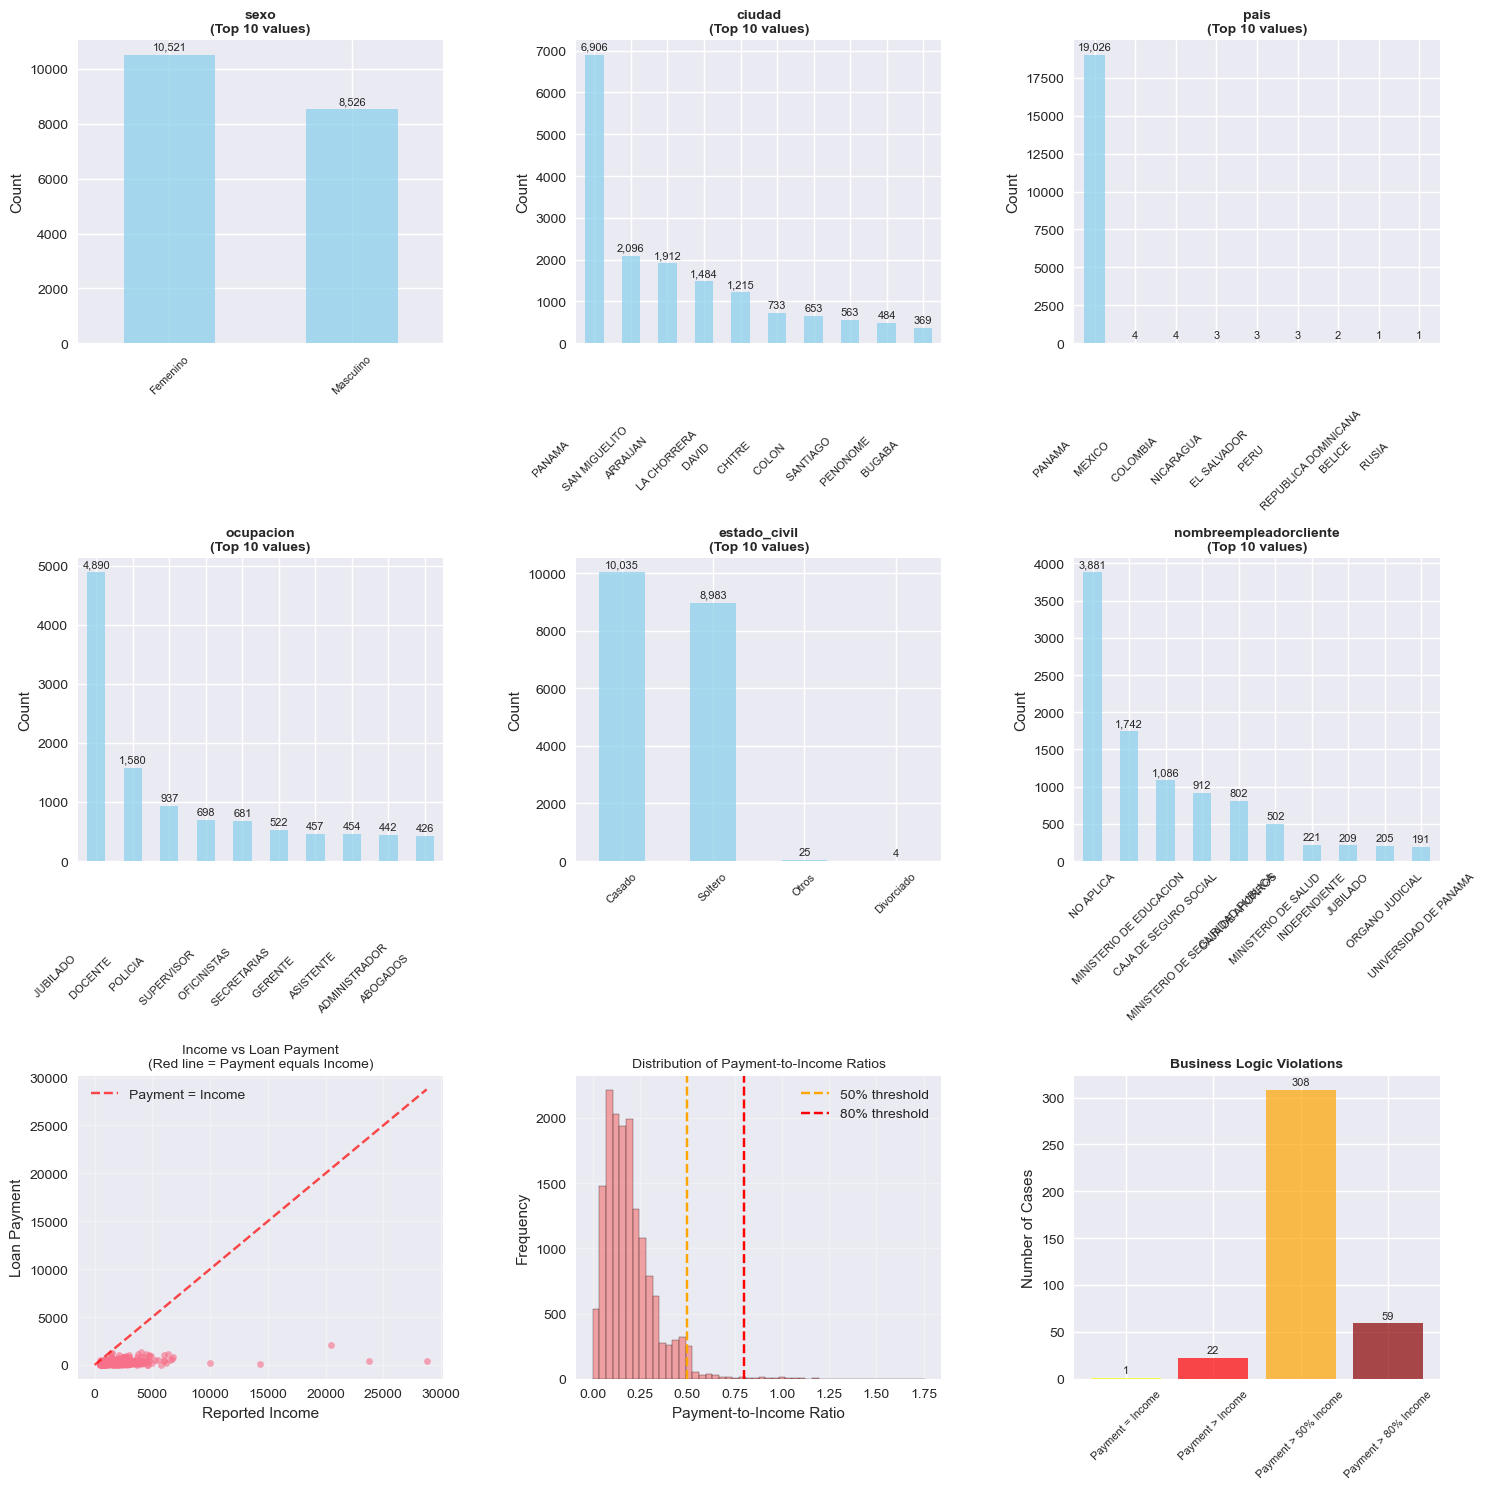


✅ DETAILED EDA STEP 1-4 COMPLETED!
📋 Next steps: Data cleaning recommendations and homologation strategies


In [13]:
# =============================================================================
# STEP 4: VISUALIZATION OF KEY FINDINGS
# =============================================================================

def visualize_categorical_and_validation_findings(df, cat_cols, validation_data=None):
    """
    Create visualizations for categorical analysis and business logic validation
    """
    print(f"\n📊 CREATING VISUALIZATIONS")
    print("="*50)
    
    # Set up the plotting area
    n_cat_plots = min(6, len(cat_cols))  # Show top 6 categorical variables
    n_validation_plots = 3 if validation_data is not None else 0
    total_plots = n_cat_plots + n_validation_plots
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (total_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    
    # Plot categorical variables
    for i, col in enumerate(cat_cols[:n_cat_plots]):
        if col in df.columns:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            
            # Get top 10 values for plotting
            value_counts = df[col].value_counts().head(10)
            
            # Create bar plot
            ax = axes[row, col_idx]
            value_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
            ax.set_title(f'{col}\n(Top 10 values)', fontsize=10, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
            # Add value labels on bars
            for j, (val, count) in enumerate(value_counts.items()):
                ax.text(j, count + max(value_counts) * 0.01, f'{count:,}', 
                       ha='center', va='bottom', fontsize=8)
            
            plot_idx += 1
    
    # Plot validation results if available
    if validation_data is not None and len(validation_data) > 0:
        # Plot 1: Income vs Payment scatter
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Sample data for plotting (to avoid overcrowding)
            sample_size = min(1000, len(validation_data))
            sample_data = validation_data.sample(sample_size)
            
            scatter = ax.scatter(sample_data['ingresos_reportados'], 
                               sample_data['monto_letra'], 
                               alpha=0.6, s=20)
            
            # Add diagonal line (payment = income)
            max_val = max(sample_data['ingresos_reportados'].max(), 
                         sample_data['monto_letra'].max())
            ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Payment = Income')
            
            ax.set_xlabel('Reported Income')
            ax.set_ylabel('Loan Payment')
            ax.set_title('Income vs Loan Payment\n(Red line = Payment equals Income)', fontsize=10)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plot_idx += 1
        
        # Plot 2: Payment-to-Income Ratio Distribution
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Filter extreme outliers for better visualization
            ratio_data = validation_data['payment_income_ratio']
            ratio_filtered = ratio_data[ratio_data <= 2]  # Remove ratios > 200%
            
            ax.hist(ratio_filtered, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
            ax.axvline(0.5, color='orange', linestyle='--', label='50% threshold')
            ax.axvline(0.8, color='red', linestyle='--', label='80% threshold')
            ax.set_xlabel('Payment-to-Income Ratio')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution of Payment-to-Income Ratios', fontsize=10)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plot_idx += 1
        
        # Plot 3: Business Logic Violations Summary
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Count violations
            violations = {
                'Payment = Income': validation_data['flag_equal_payment_income'].sum(),
                'Payment > Income': validation_data['flag_payment_exceeds_income'].sum(),
                'Payment > 50% Income': validation_data['flag_high_payment_ratio'].sum(),
                'Payment > 80% Income': validation_data['flag_very_high_payment_ratio'].sum()
            }
            
            violation_names = list(violations.keys())
            violation_counts = list(violations.values())
            
            bars = ax.bar(violation_names, violation_counts, color=['yellow', 'red', 'orange', 'darkred'], alpha=0.7)
            ax.set_title('Business Logic Violations', fontsize=10, fontweight='bold')
            ax.set_ylabel('Number of Cases')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
            # Add value labels on bars
            for bar, count in zip(bars, violation_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + max(violation_counts) * 0.01,
                       f'{count:,}', ha='center', va='bottom', fontsize=8)
            
            plot_idx += 1
    
    # Hide empty subplots
    for i in range(plot_idx, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_categorical_and_validation_findings(
    df_clientes, 
    target_categorical_cols, 
    validation_results if 'validation_results' in locals() else None
)

print(f"\n✅ DETAILED EDA STEP 1-4 COMPLETED!")
print(f"📋 Next steps: Data cleaning recommendations and homologation strategies")

## Data cleaning recommendations and homologation strategies

🧹 DATA CLEANING AND FEATURE HOMOLOGATION
📋 Objective: Consolidate categorical features to improve model performance
🎯 Strategy: Group categories representing <40% into 'Others' category
📊 Focus: ocupacion, ciudad, nombreempleadorcliente, cargoempleocliente

🎯 ANALYZING 7 CATEGORICAL VARIABLES FOR CONSOLIDATION

🔍 CONSOLIDATION ANALYSIS: ocupacion
📊 Current state:
   Total non-null values: 19,045
   Unique categories: 226
   Missing values: 2

📈 Consolidation recommendation:
   Keep as separate: 22 categories (14,459 records, 75.9%)
   Consolidate to 'Others': 204 categories (4,586 records, 24.1%)

🏆 Top categories to keep:
    1. 'JUBILADO                                     ': 4,890 (25.7%)
    2. 'DOCENTE                                      ': 1,580 (8.3%)
    3. 'POLICIA                                      ': 937 (4.9%)
    4. 'SUPERVISOR                                   ': 698 (3.7%)
    5. 'OFICINISTAS                                  ': 681 (3.6%)
    6. 'SECRETARIAS          

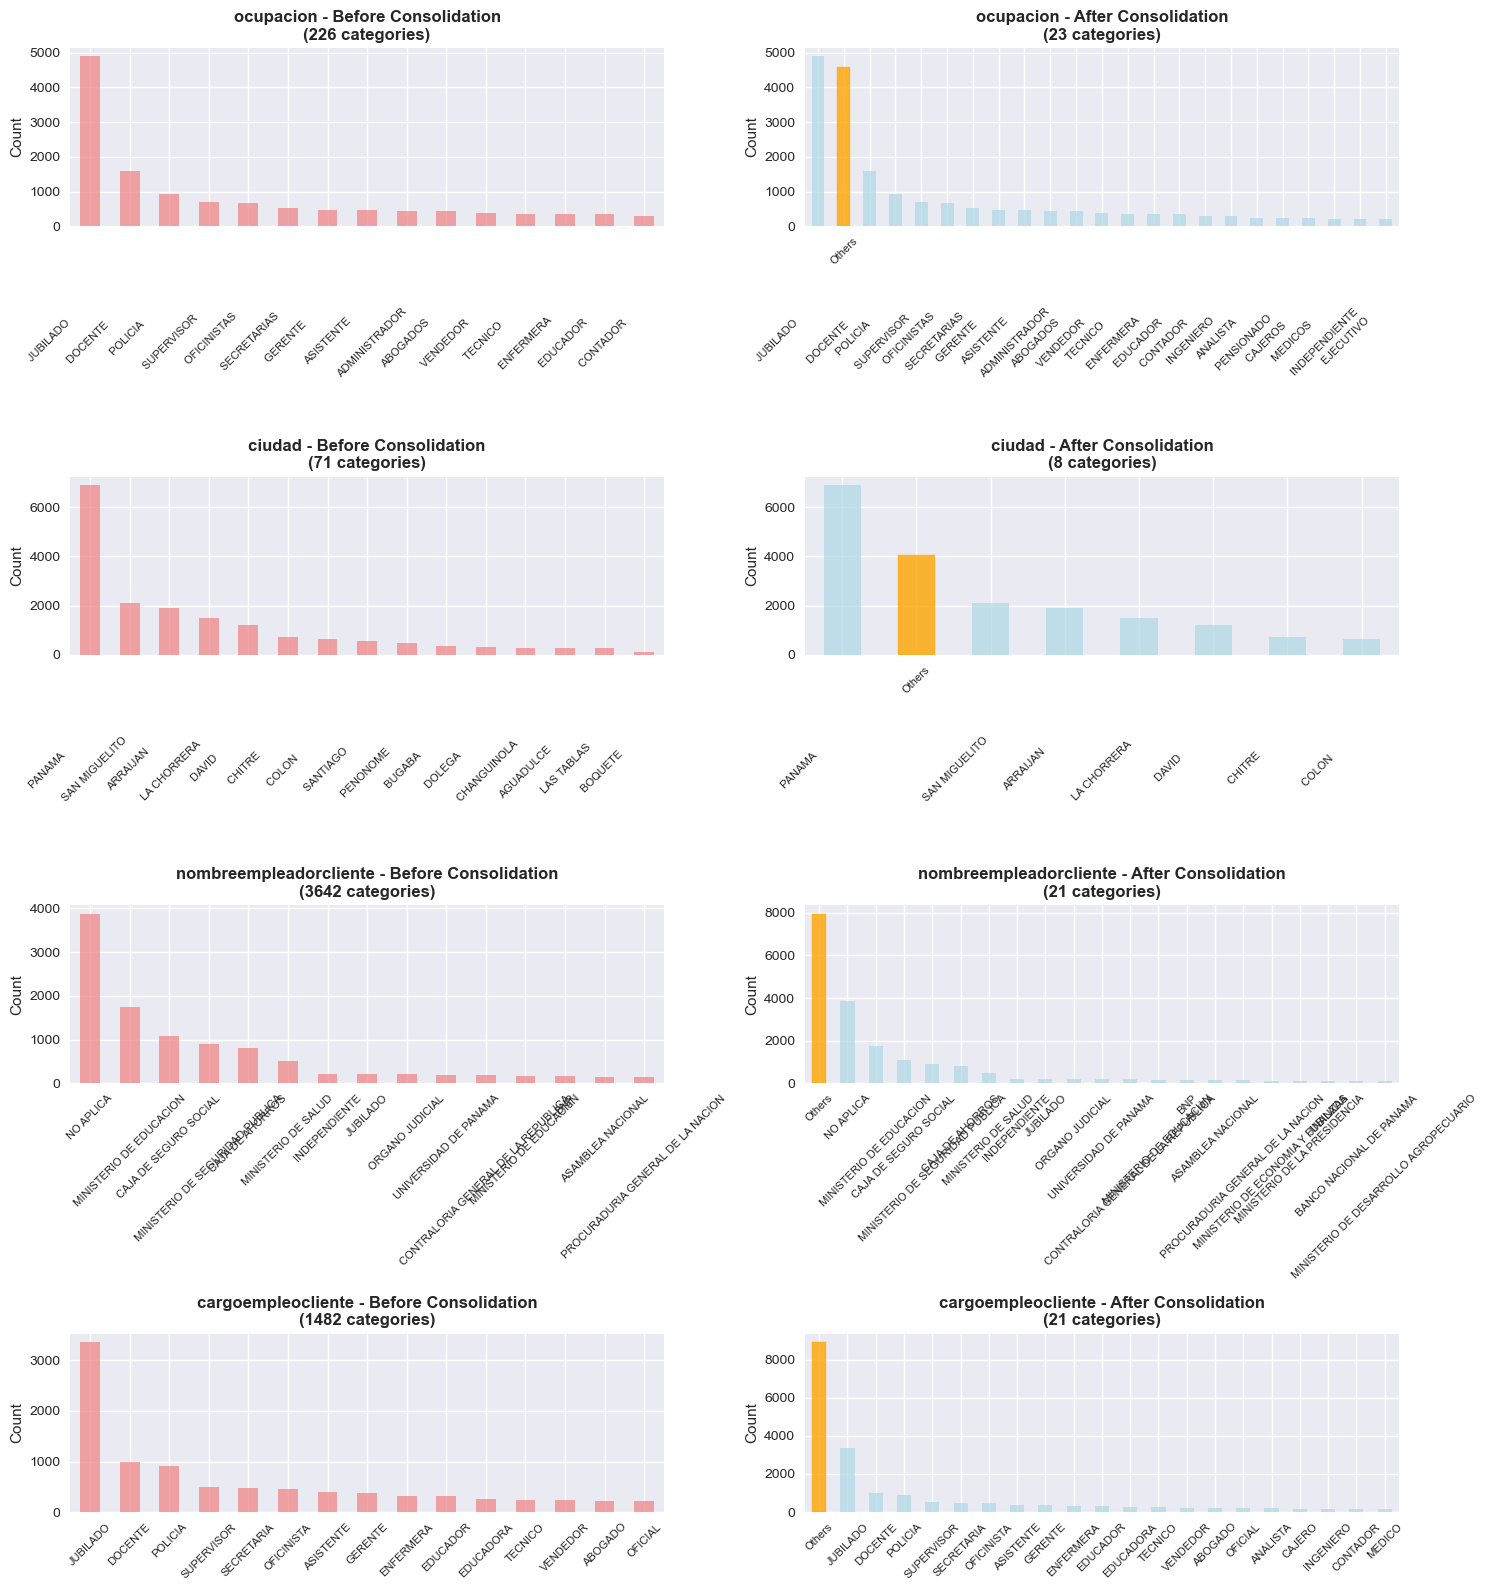


🔧 ADDITIONAL DATA QUALITY IMPROVEMENTS
🧹 Applying additional cleaning steps:
   📝 Standardizing text in: ocupacion_consolidated
   📝 Standardizing text in: ciudad_consolidated
   📝 Standardizing text in: nombreempleadorcliente_consolidated
   📝 Standardizing text in: cargoempleocliente_consolidated
   🏷️  Created missing value flag: missing_fechaingresoempleo
   🏷️  Created missing value flag: missing_nombreempleadorcliente
   🏷️  Created missing value flag: missing_cargoempleocliente
   🔧 Creating derived features:
     - is_retired (from ocupacion)
     - age_group (from edad)
     - payment_to_income_ratio

✅ FINAL DATASET SUMMARY
📊 Final dataset shape: (19047, 32)
💾 Memory usage: 12.67 MB

📋 Final columns (32):
    1. cliente                             | int32           | Non-null: 19,047
    2. identificador_unico                 | object          | Non-null: 19,047
    3. segmento                            | category        | Non-null: 19,047
    4. edad                       

In [14]:
# =============================================================================
# STEP 5: DATA CLEANING AND FEATURE HOMOLOGATION STRATEGIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("🧹 DATA CLEANING AND FEATURE HOMOLOGATION")
print("="*80)
print("📋 Objective: Consolidate categorical features to improve model performance")
print("🎯 Strategy: Group categories representing <40% into 'Others' category")
print("📊 Focus: ocupacion, ciudad, nombreempleadorcliente, cargoempleocliente")

# =============================================================================
# STEP 5.1: CATEGORICAL FEATURE CONSOLIDATION STRATEGY
# =============================================================================

def analyze_categorical_for_consolidation(df, column_name, min_frequency_pct=5.0, top_categories_pct=60.0):
    """
    Analyze categorical column and recommend consolidation strategy
    
    Parameters:
    - df: DataFrame
    - column_name: Column to analyze
    - min_frequency_pct: Minimum frequency percentage to keep as separate category
    - top_categories_pct: Percentage of data that top categories should represent
    """
    print(f"\n🔍 CONSOLIDATION ANALYSIS: {column_name}")
    print("="*60)
    
    if column_name not in df.columns:
        print(f"❌ Column '{column_name}' not found!")
        return None
    
    # Get value counts and percentages
    value_counts = df[column_name].value_counts()
    total_non_null = df[column_name].notna().sum()
    value_percentages = (value_counts / total_non_null * 100).round(2)
    
    # Calculate cumulative percentages
    cumulative_pct = value_percentages.cumsum()
    
    print(f"📊 Current state:")
    print(f"   Total non-null values: {total_non_null:,}")
    print(f"   Unique categories: {len(value_counts):,}")
    print(f"   Missing values: {df[column_name].isnull().sum():,}")
    
    # Find categories that represent the target percentage
    top_categories_mask = cumulative_pct <= top_categories_pct
    top_categories = value_counts[top_categories_mask]
    
    # Find categories above minimum frequency
    frequent_categories_mask = value_percentages >= min_frequency_pct
    frequent_categories = value_counts[frequent_categories_mask]
    
    # Combine both criteria (categories that are either in top % OR above min frequency)
    keep_categories = set(top_categories.index) | set(frequent_categories.index)
    consolidate_categories = set(value_counts.index) - keep_categories
    
    # Calculate statistics
    keep_count = sum(value_counts[cat] for cat in keep_categories)
    consolidate_count = sum(value_counts[cat] for cat in consolidate_categories)
    
    print(f"\n📈 Consolidation recommendation:")
    print(f"   Keep as separate: {len(keep_categories):,} categories ({keep_count:,} records, {keep_count/total_non_null*100:.1f}%)")
    print(f"   Consolidate to 'Others': {len(consolidate_categories):,} categories ({consolidate_count:,} records, {consolidate_count/total_non_null*100:.1f}%)")
    
    # Show top categories to keep
    print(f"\n🏆 Top categories to keep:")
    keep_categories_sorted = [(cat, value_counts[cat], value_percentages[cat]) 
                             for cat in sorted(keep_categories, key=lambda x: value_counts[x], reverse=True)]
    
    for i, (cat, count, pct) in enumerate(keep_categories_sorted[:15], 1):
        print(f"   {i:2d}. '{cat}': {count:,} ({pct:.1f}%)")
    
    if len(keep_categories_sorted) > 15:
        print(f"   ... and {len(keep_categories_sorted) - 15} more categories")
    
    # Show sample of categories to consolidate
    if consolidate_categories:
        print(f"\n📦 Sample categories to consolidate (showing first 10):")
        consolidate_sorted = sorted(consolidate_categories, key=lambda x: value_counts[x], reverse=True)
        for i, cat in enumerate(consolidate_sorted[:10], 1):
            count = value_counts[cat]
            pct = value_percentages[cat]
            print(f"   {i:2d}. '{cat}': {count:,} ({pct:.1f}%)")
        
        if len(consolidate_sorted) > 10:
            print(f"   ... and {len(consolidate_sorted) - 10} more categories")
    
    return {
        'column_name': column_name,
        'keep_categories': list(keep_categories),
        'consolidate_categories': list(consolidate_categories),
        'keep_count': keep_count,
        'consolidate_count': consolidate_count,
        'original_unique': len(value_counts),
        'final_unique': len(keep_categories) + (1 if consolidate_categories else 0)
    }

# =============================================================================
# STEP 5.2: APPLY CONSOLIDATION ANALYSIS TO KEY CATEGORICAL VARIABLES
# =============================================================================

# Define the categorical columns to analyze and consolidate
target_columns_for_consolidation = [
    'ocupacion',
    'ciudad', 
    'nombreempleadorcliente',
    'cargoempleocliente',
    'sexo',
    'estado_civil',
    'pais'
]

# Store consolidation recommendations
consolidation_recommendations = {}

print(f"\n🎯 ANALYZING {len(target_columns_for_consolidation)} CATEGORICAL VARIABLES FOR CONSOLIDATION")
print("="*80)

for column in target_columns_for_consolidation:
    if column in df_clientes.columns:
        # Use different thresholds based on column characteristics
        if column in ['sexo', 'estado_civil', 'pais']:
            # For low-cardinality columns, use lower thresholds
            recommendation = analyze_categorical_for_consolidation(
                df_clientes, column, min_frequency_pct=2.0, top_categories_pct=80.0
            )
        elif column in ['ciudad']:
            # For geographic data, be more selective
            recommendation = analyze_categorical_for_consolidation(
                df_clientes, column, min_frequency_pct=3.0, top_categories_pct=70.0
            )
        else:
            # For high-cardinality columns like ocupacion, nombreempleadorcliente, cargoempleocliente
            recommendation = analyze_categorical_for_consolidation(
                df_clientes, column, min_frequency_pct=1.0, top_categories_pct=60.0
            )
        
        if recommendation:
            consolidation_recommendations[column] = recommendation
    else:
        print(f"⚠️  Column '{column}' not found in dataset")

# =============================================================================
# STEP 5.3: IMPLEMENT CONSOLIDATION FUNCTION (FIXED FOR CATEGORICAL DTYPE)
# =============================================================================

def consolidate_categorical_column(df, column_name, keep_categories, others_label="Others"):
    """
    Consolidate categorical column by grouping low-frequency categories
    FIXED: Handles pandas categorical dtype properly
    
    Parameters:
    - df: DataFrame
    - column_name: Column to consolidate
    - keep_categories: List of categories to keep as-is
    - others_label: Label for consolidated categories
    
    Returns:
    - Series with consolidated categories
    """
    if column_name not in df.columns:
        print(f"❌ Column '{column_name}' not found!")
        return df[column_name].copy()
    
    print(f"   🔧 Processing {column_name} (dtype: {df[column_name].dtype})...")
    
    # Create a copy of the column
    consolidated_column = df[column_name].copy()
    
    # Check if column is categorical dtype and convert to string first
    if pd.api.types.is_categorical_dtype(consolidated_column):
        print(f"   📝 Converting categorical to string for processing...")
        consolidated_column = consolidated_column.astype(str)
    
    # Handle NaN values - convert to string representation temporarily
    consolidated_column = consolidated_column.fillna('__MISSING__')
    
    # Create mask for values to replace
    mask = ~consolidated_column.isin(keep_categories)
    
    # Don't replace the missing value placeholder
    mask = mask & (consolidated_column != '__MISSING__')
    
    # Apply consolidation
    consolidated_column.loc[mask] = others_label
    
    # Convert missing values back to NaN
    consolidated_column = consolidated_column.replace('__MISSING__', np.nan)
    
    print(f"   ✅ Successfully consolidated {column_name}")
    return consolidated_column

# =============================================================================
# STEP 5.4: CREATE CONSOLIDATED DATASET (UPDATED)
# =============================================================================

print(f"\n🔧 CREATING CONSOLIDATED DATASET")
print("="*50)

# Create a copy of the original dataset
df_clientes_consolidated = df_clientes.copy()

# Apply consolidation to each recommended column
consolidation_summary = {}

for column, recommendation in consolidation_recommendations.items():
    print(f"\n🔄 Consolidating: {column}")
    
    # Apply consolidation
    original_unique = df_clientes_consolidated[column].nunique()
    
    df_clientes_consolidated[f"{column}_consolidated"] = consolidate_categorical_column(
        df_clientes_consolidated, 
        column, 
        recommendation['keep_categories'],
        others_label="Others"
    )
    
    new_unique = df_clientes_consolidated[f"{column}_consolidated"].nunique()
    
    # Calculate reduction
    reduction_pct = ((original_unique - new_unique) / original_unique * 100) if original_unique > 0 else 0
    
    print(f"   📊 Original categories: {original_unique:,}")
    print(f"   📊 Consolidated categories: {new_unique:,}")
    print(f"   📈 Reduction: {reduction_pct:.1f}%")
    
    # Show top categories in consolidated column
    new_value_counts = df_clientes_consolidated[f"{column}_consolidated"].value_counts()
    print(f"   🏆 Top 5 categories after consolidation:")
    for i, (cat, count) in enumerate(new_value_counts.head(5).items(), 1):
        pct = count / len(df_clientes_consolidated) * 100
        print(f"     {i}. '{cat}': {count:,} ({pct:.1f}%)")
    
    # Store summary
    consolidation_summary[column] = {
        'original_unique': original_unique,
        'consolidated_unique': new_unique,
        'reduction_pct': reduction_pct,
        'others_count': (df_clientes_consolidated[f"{column}_consolidated"] == "Others").sum()
    }

print(f"\n✅ CONSOLIDATION COMPLETED SUCCESSFULLY!")

# =============================================================================
# STEP 5.5: VALIDATION AND QUALITY CHECKS
# =============================================================================

print(f"\n✅ CONSOLIDATION VALIDATION")
print("="*50)

def validate_consolidation(df_original, df_consolidated, column_mapping):
    """
    Validate that consolidation was applied correctly
    """
    validation_results = {}
    
    for original_col, consolidated_col in column_mapping.items():
        if original_col in df_original.columns and consolidated_col in df_consolidated.columns:
            # Check that no data was lost
            original_non_null = df_original[original_col].notna().sum()
            consolidated_non_null = df_consolidated[consolidated_col].notna().sum()
            
            # Check that Others category was created appropriately
            others_count = (df_consolidated[consolidated_col] == "Others").sum()
            
            validation_results[original_col] = {
                'data_preserved': original_non_null == consolidated_non_null,
                'others_created': others_count > 0,
                'original_non_null': original_non_null,
                'consolidated_non_null': consolidated_non_null,
                'others_count': others_count
            }
            
            print(f"📊 {original_col}:")
            print(f"   Data preserved: {'✅' if validation_results[original_col]['data_preserved'] else '❌'}")
            print(f"   Others category created: {'✅' if validation_results[original_col]['others_created'] else '❌'}")
            print(f"   Records in 'Others': {others_count:,}")
    
    return validation_results

# Create column mapping for validation
column_mapping = {col: f"{col}_consolidated" for col in consolidation_recommendations.keys()}

# Validate consolidation
validation_results = validate_consolidation(df_clientes, df_clientes_consolidated, column_mapping)

# =============================================================================
# STEP 5.6: SUMMARY STATISTICS AND RECOMMENDATIONS
# =============================================================================

print(f"\n📈 CONSOLIDATION SUMMARY")
print("="*50)

total_original_categories = sum(summary['original_unique'] for summary in consolidation_summary.values())
total_consolidated_categories = sum(summary['consolidated_unique'] for summary in consolidation_summary.values())
overall_reduction = ((total_original_categories - total_consolidated_categories) / total_original_categories * 100)

print(f"📊 Overall consolidation impact:")
print(f"   Total original categories: {total_original_categories:,}")
print(f"   Total consolidated categories: {total_consolidated_categories:,}")
print(f"   Overall reduction: {overall_reduction:.1f}%")

print(f"\n📋 Detailed breakdown:")
for column, summary in consolidation_summary.items():
    print(f"   {column}:")
    print(f"     {summary['original_unique']:,} → {summary['consolidated_unique']:,} categories ({summary['reduction_pct']:.1f}% reduction)")
    print(f"     {summary['others_count']:,} records moved to 'Others'")

# =============================================================================
# STEP 5.7: VISUALIZATION OF CONSOLIDATION IMPACT
# =============================================================================

print(f"\n📊 CREATING CONSOLIDATION IMPACT VISUALIZATIONS")
print("="*50)

def visualize_consolidation_impact(df_original, df_consolidated, consolidation_summary, max_cols=4):
    """
    Create before/after visualizations for consolidation
    """
    # Select columns to visualize (limit to avoid overcrowding)
    columns_to_plot = list(consolidation_summary.keys())[:max_cols]
    
    fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(15, 4*len(columns_to_plot)))
    if len(columns_to_plot) == 1:
        axes = axes.reshape(1, -1)
    
    for i, column in enumerate(columns_to_plot):
        # Before consolidation
        ax1 = axes[i, 0]
        value_counts_original = df_original[column].value_counts().head(15)
        value_counts_original.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
        ax1.set_title(f'{column} - Before Consolidation\n({consolidation_summary[column]["original_unique"]} categories)', 
                     fontweight='bold')
        ax1.set_xlabel('')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45, labelsize=8)
        
        # After consolidation
        ax2 = axes[i, 1]
        consolidated_col = f"{column}_consolidated"
        value_counts_consolidated = df_consolidated[consolidated_col].value_counts()
        value_counts_consolidated.plot(kind='bar', ax=ax2, color='lightblue', alpha=0.7)
        ax2.set_title(f'{column} - After Consolidation\n({consolidation_summary[column]["consolidated_unique"]} categories)', 
                     fontweight='bold')
        ax2.set_xlabel('')
        ax2.set_ylabel('Count')
        ax2.tick_params(axis='x', rotation=45, labelsize=8)
        
        # Highlight Others category
        if 'Others' in value_counts_consolidated.index:
            others_idx = list(value_counts_consolidated.index).index('Others')
            ax2.patches[others_idx].set_color('orange')
            ax2.patches[others_idx].set_alpha(0.8)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_consolidation_impact(df_clientes, df_clientes_consolidated, consolidation_summary)

# =============================================================================
# STEP 5.8: ADDITIONAL DATA QUALITY IMPROVEMENTS
# =============================================================================

print(f"\n🔧 ADDITIONAL DATA QUALITY IMPROVEMENTS")
print("="*50)

def apply_additional_cleaning(df):
    """
    Apply additional data quality improvements
    """
    df_cleaned = df.copy()
    
    print("🧹 Applying additional cleaning steps:")
    
    # 1. Standardize text fields (remove extra spaces, standardize case)
    text_columns = ['ocupacion_consolidated', 'ciudad_consolidated', 
                   'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']
    
    for col in text_columns:
        if col in df_cleaned.columns:
            print(f"   📝 Standardizing text in: {col}")
            # Convert to string first, then clean
            df_cleaned[col] = df_cleaned[col].astype(str)
            # Remove extra spaces and standardize case
            df_cleaned[col] = df_cleaned[col].str.strip().str.title()
            # Handle 'Others' category specifically
            df_cleaned[col] = df_cleaned[col].replace('Others', 'Others')
            # Handle NaN that became 'Nan'
            df_cleaned[col] = df_cleaned[col].replace('Nan', np.nan)
    
    # 2. Create binary flags for missing values in important columns
    important_columns = ['fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente']
    
    for col in important_columns:
        if col in df_cleaned.columns:
            flag_col = f"missing_{col}"
            df_cleaned[flag_col] = df_cleaned[col].isnull().astype(int)
            print(f"   🏷️  Created missing value flag: {flag_col}")
    
    # 3. Create derived features
    print("   🔧 Creating derived features:")
    
    # Employment status derived from occupation
    if 'ocupacion_consolidated' in df_cleaned.columns:
        df_cleaned['is_retired'] = (df_cleaned['ocupacion_consolidated'].str.contains('Jubilado', na=False)).astype(int)
        print("     - is_retired (from ocupacion)")
    
    # Age groups (if age column exists)
    if 'edad' in df_cleaned.columns:
        df_cleaned['age_group'] = pd.cut(df_cleaned['edad'], 
                                       bins=[0, 25, 35, 45, 55, 65, 100], 
                                       labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
        print("     - age_group (from edad)")
    
    # 4. Income-to-payment ratio (if both exist)
    if 'ingresos_reportados' in df_cleaned.columns and 'monto_letra' in df_cleaned.columns:
        df_cleaned['payment_to_income_ratio'] = (df_cleaned['monto_letra'] / 
                                               df_cleaned['ingresos_reportados']).fillna(0)
        # Cap extreme ratios
        df_cleaned['payment_to_income_ratio'] = df_cleaned['payment_to_income_ratio'].clip(0, 2)
        print("     - payment_to_income_ratio")
    
    return df_cleaned

# Apply additional cleaning
df_clientes_final = apply_additional_cleaning(df_clientes_consolidated)

print(f"\n✅ FINAL DATASET SUMMARY")
print("="*50)
print(f"📊 Final dataset shape: {df_clientes_final.shape}")
print(f"💾 Memory usage: {df_clientes_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show final column summary
print(f"\n📋 Final columns ({len(df_clientes_final.columns)}):")
for i, col in enumerate(df_clientes_final.columns, 1):
    col_type = str(df_clientes_final[col].dtype)
    non_null = df_clientes_final[col].notna().sum()
    print(f"   {i:2d}. {col:<35} | {col_type:<15} | Non-null: {non_null:,}")

print(f"\n🎉 DATA CONSOLIDATION AND CLEANING COMPLETE!")
print("📝 Next steps:")
print("   1. Feature engineering and encoding")
print("   2. Train-test split")
print("   3. Model training and evaluation")
print("   4. Model validation and testing")

## Matches Between Datasets(apc-clientes)

In [15]:
# =============================================================================
# STEP 6: DATASET RELATIONSHIP VALIDATION - df_clientes_final vs df_apc
# =============================================================================

print("🔍 DATASET RELATIONSHIP VALIDATION")
print("="*80)
print("📋 Objective: Validate relationship between df_clientes_final and df_apc")
print("🔑 Key: identificador_unico")
print("📊 Analysis: Matches, non-matches, and overlap statistics")

# =============================================================================
# STEP 6.1: BASIC DATASET INFORMATION
# =============================================================================

print(f"\n📊 BASIC DATASET INFORMATION")
print("="*50)

print(f"df_clientes_final:")
print(f"   Shape: {df_clientes_final.shape}")
print(f"   Unique identificador_unico: {df_clientes_final['identificador_unico'].nunique():,}")
print(f"   Total records: {len(df_clientes_final):,}")

print(f"\ndf_apc:")
print(f"   Shape: {df_apc.shape}")
print(f"   Unique identificador_unico: {df_apc['identificador_unico'].nunique():,}")
print(f"   Total records: {len(df_apc):,}")

# Check for missing values in the key column
clientes_missing_id = df_clientes_final['identificador_unico'].isnull().sum()
apc_missing_id = df_apc['identificador_unico'].isnull().sum()

print(f"\n🔍 Missing identificador_unico:")
print(f"   df_clientes_final: {clientes_missing_id:,} missing")
print(f"   df_apc: {apc_missing_id:,} missing")

🔍 DATASET RELATIONSHIP VALIDATION
📋 Objective: Validate relationship between df_clientes_final and df_apc
🔑 Key: identificador_unico
📊 Analysis: Matches, non-matches, and overlap statistics

📊 BASIC DATASET INFORMATION
df_clientes_final:
   Shape: (19047, 32)
   Unique identificador_unico: 15,000
   Total records: 19,047

df_apc:
   Shape: (32170, 11)
   Unique identificador_unico: 32,169
   Total records: 32,170

🔍 Missing identificador_unico:
   df_clientes_final: 0 missing
   df_apc: 1 missing


In [16]:
# =============================================================================
# STEP 6.2: DETAILED RELATIONSHIP ANALYSIS
# =============================================================================

def analyze_dataset_relationship(df1, df2, key_column, df1_name="Dataset1", df2_name="Dataset2"):
    """
    Comprehensive analysis of relationship between two datasets based on a key column
    """
    print(f"\n🔬 DETAILED RELATIONSHIP ANALYSIS")
    print("="*60)
    
    # Get unique IDs from both datasets (excluding NaN)
    ids_df1 = set(df1[key_column].dropna().unique())
    ids_df2 = set(df2[key_column].dropna().unique())
    
    # Calculate overlaps
    ids_in_both = ids_df1.intersection(ids_df2)
    ids_only_df1 = ids_df1 - ids_df2
    ids_only_df2 = ids_df2 - ids_df1
    
    # Basic statistics
    total_unique_ids = len(ids_df1.union(ids_df2))
    
    print(f"📈 OVERLAP STATISTICS:")
    print(f"   Total unique IDs across both datasets: {total_unique_ids:,}")
    print(f"   IDs in {df1_name}: {len(ids_df1):,}")
    print(f"   IDs in {df2_name}: {len(ids_df2):,}")
    print(f"   IDs in BOTH datasets: {len(ids_in_both):,}")
    print(f"   IDs ONLY in {df1_name}: {len(ids_only_df1):,}")
    print(f"   IDs ONLY in {df2_name}: {len(ids_only_df2):,}")
    
    # Calculate percentages
    if len(ids_df1) > 0:
        pct_df1_in_df2 = (len(ids_in_both) / len(ids_df1)) * 100
        print(f"\n📊 COVERAGE ANALYSIS:")
        print(f"   {pct_df1_in_df2:.1f}% of {df1_name} IDs found in {df2_name}")
    
    if len(ids_df2) > 0:
        pct_df2_in_df1 = (len(ids_in_both) / len(ids_df2)) * 100
        print(f"   {pct_df2_in_df1:.1f}% of {df2_name} IDs found in {df1_name}")
    
    if total_unique_ids > 0:
        pct_overlap = (len(ids_in_both) / total_unique_ids) * 100
        print(f"   {pct_overlap:.1f}% overall overlap of all unique IDs")
    
    # Record-level analysis
    print(f"\n📋 RECORD-LEVEL ANALYSIS:")
    
    # Records in df1 that have matches in df2
    df1_records_with_match = df1[df1[key_column].isin(ids_in_both)]
    df1_records_without_match = df1[df1[key_column].isin(ids_only_df1)]
    
    print(f"   {df1_name} records with match in {df2_name}: {len(df1_records_with_match):,}")
    print(f"   {df1_name} records without match in {df2_name}: {len(df1_records_without_match):,}")
    
    # Records in df2 that have matches in df1
    df2_records_with_match = df2[df2[key_column].isin(ids_in_both)]
    df2_records_without_match = df2[df2[key_column].isin(ids_only_df2)]
    
    print(f"   {df2_name} records with match in {df1_name}: {len(df2_records_with_match):,}")
    print(f"   {df2_name} records without match in {df1_name}: {len(df2_records_without_match):,}")
    
    # Check for duplicates within each dataset
    print(f"\n🔍 DUPLICATE ANALYSIS:")
    df1_duplicates = df1[key_column].duplicated().sum()
    df2_duplicates = df2[key_column].duplicated().sum()
    
    print(f"   {df1_name} duplicate IDs: {df1_duplicates:,}")
    print(f"   {df2_name} duplicate IDs: {df2_duplicates:,}")
    
    if df2_duplicates > 0:
        print(f"\n📊 {df2_name} ID frequency analysis:")
        id_counts = df2[key_column].value_counts()
        print(f"   IDs appearing once: {(id_counts == 1).sum():,}")
        print(f"   IDs appearing multiple times: {(id_counts > 1).sum():,}")
        print(f"   Maximum frequency: {id_counts.max():,}")
        print(f"   Average frequency: {id_counts.mean():.2f}")
        
        # Show top duplicated IDs
        top_duplicated = id_counts[id_counts > 1].head(10)
        if len(top_duplicated) > 0:
            print(f"\n   Top duplicated IDs in {df2_name}:")
            for i, (id_val, count) in enumerate(top_duplicated.items(), 1):
                print(f"     {i:2d}. {id_val}: {count:,} records")
    
    return {
        'ids_df1': ids_df1,
        'ids_df2': ids_df2,
        'ids_in_both': ids_in_both,
        'ids_only_df1': ids_only_df1,
        'ids_only_df2': ids_only_df2,
        'df1_records_with_match': df1_records_with_match,
        'df1_records_without_match': df1_records_without_match,
        'df2_records_with_match': df2_records_with_match,
        'df2_records_without_match': df2_records_without_match,
        'df1_duplicates': df1_duplicates,
        'df2_duplicates': df2_duplicates
    }

# Perform the analysis
relationship_analysis = analyze_dataset_relationship(
    df_clientes_final, 
    df_apc, 
    'identificador_unico',
    'df_clientes_final',
    'df_apc'
)


🔬 DETAILED RELATIONSHIP ANALYSIS
📈 OVERLAP STATISTICS:
   Total unique IDs across both datasets: 44,951
   IDs in df_clientes_final: 15,000
   IDs in df_apc: 32,169
   IDs in BOTH datasets: 2,218
   IDs ONLY in df_clientes_final: 12,782
   IDs ONLY in df_apc: 29,951

📊 COVERAGE ANALYSIS:
   14.8% of df_clientes_final IDs found in df_apc
   6.9% of df_apc IDs found in df_clientes_final
   4.9% overall overlap of all unique IDs

📋 RECORD-LEVEL ANALYSIS:
   df_clientes_final records with match in df_apc: 3,253
   df_clientes_final records without match in df_apc: 15,794
   df_apc records with match in df_clientes_final: 2,218
   df_apc records without match in df_clientes_final: 29,951

🔍 DUPLICATE ANALYSIS:
   df_clientes_final duplicate IDs: 4,047
   df_apc duplicate IDs: 0


In [17]:
# =============================================================================
# STEP 6.3: SAMPLE DATA INSPECTION
# =============================================================================

print(f"\n🔍 SAMPLE DATA INSPECTION")
print("="*50)

# Show sample of matching records
if len(relationship_analysis['ids_in_both']) > 0:
    print(f"📋 Sample of IDs that appear in BOTH datasets:")
    sample_matching_ids = list(relationship_analysis['ids_in_both'])[:5]
    for i, id_val in enumerate(sample_matching_ids, 1):
        print(f"   {i}. {id_val}")
        
        # Show records from both datasets for this ID
        clientes_records = df_clientes_final[df_clientes_final['identificador_unico'] == id_val]
        apc_records = df_apc[df_apc['identificador_unico'] == id_val]
        
        print(f"      df_clientes_final: {len(clientes_records)} record(s)")
        print(f"      df_apc: {len(apc_records)} record(s)")

# Show sample of non-matching records
if len(relationship_analysis['ids_only_df1']) > 0:
    print(f"\n📋 Sample of IDs ONLY in df_clientes_final:")
    sample_only_clientes = list(relationship_analysis['ids_only_df1'])[:5]
    for i, id_val in enumerate(sample_only_clientes, 1):
        print(f"   {i}. {id_val}")

if len(relationship_analysis['ids_only_df2']) > 0:
    print(f"\n📋 Sample of IDs ONLY in df_apc:")
    sample_only_apc = list(relationship_analysis['ids_only_df2'])[:5]
    for i, id_val in enumerate(sample_only_apc, 1):
        print(f"   {i}. {id_val}")



🔍 SAMPLE DATA INSPECTION
📋 Sample of IDs that appear in BOTH datasets:
   1. 8-383-960
      df_clientes_final: 2 record(s)
      df_apc: 1 record(s)
   2. 4-152-204
      df_clientes_final: 1 record(s)
      df_apc: 1 record(s)
   3. 7-93-2590
      df_clientes_final: 1 record(s)
      df_apc: 1 record(s)
   4. 9-736-185
      df_clientes_final: 1 record(s)
      df_apc: 1 record(s)
   5. 8-239-960
      df_clientes_final: 1 record(s)
      df_apc: 1 record(s)

📋 Sample of IDs ONLY in df_clientes_final:
   1. 8-257-90
   2. 4-213-223
   3. 8-237-1350
   4. 8-471-23
   5. 8-378-80

📋 Sample of IDs ONLY in df_apc:
   1. 8-725-130
   2. 8-805-566
   3. 9-741-338
   4. 4-152-802
   5. 5-23-789



📊 CREATING RELATIONSHIP VISUALIZATIONS


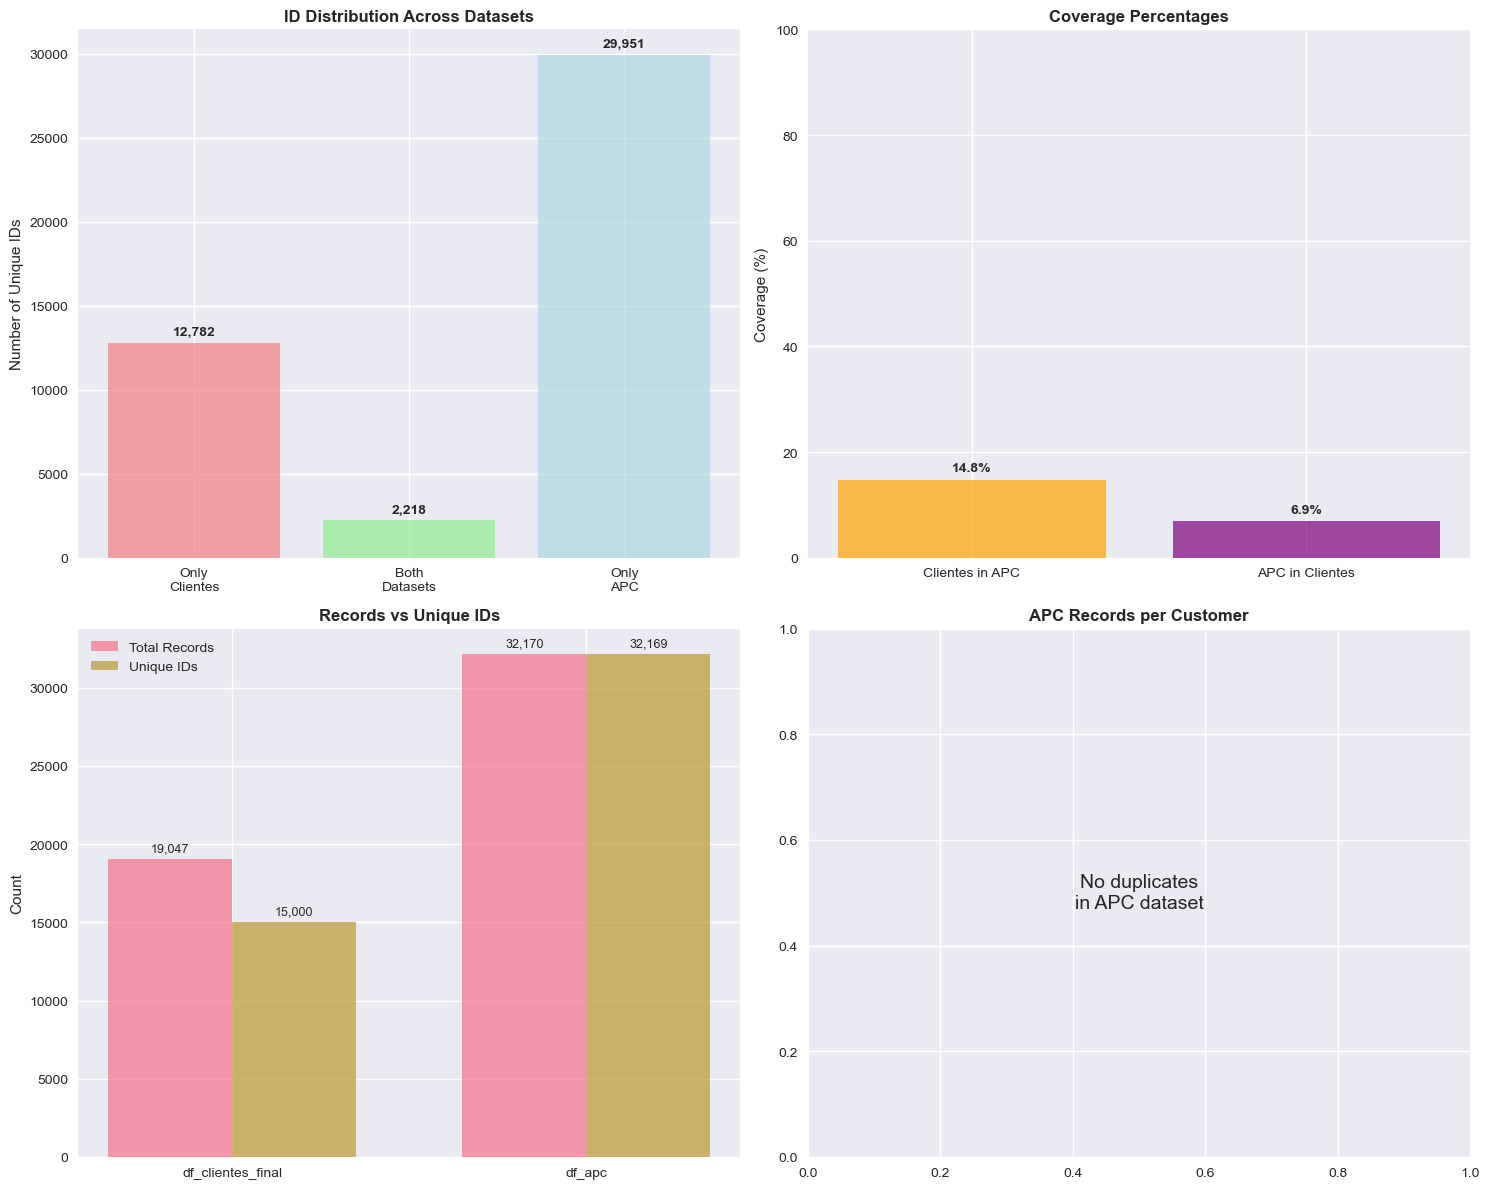

In [18]:
# =============================================================================
# STEP 6.4: VISUALIZATION OF RELATIONSHIP
# =============================================================================

print(f"\n📊 CREATING RELATIONSHIP VISUALIZATIONS")
print("="*50)

def create_relationship_visualizations(analysis_results):
    """
    Create visualizations for dataset relationship analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Venn diagram-style bar chart
    ax1 = axes[0, 0]
    categories = ['Only\nClientes', 'Both\nDatasets', 'Only\nAPC']
    values = [
        len(analysis_results['ids_only_df1']),
        len(analysis_results['ids_in_both']),
        len(analysis_results['ids_only_df2'])
    ]
    colors = ['lightcoral', 'lightgreen', 'lightblue']
    
    bars = ax1.bar(categories, values, color=colors, alpha=0.7)
    ax1.set_title('ID Distribution Across Datasets', fontweight='bold')
    ax1.set_ylabel('Number of Unique IDs')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Coverage percentages
    ax2 = axes[0, 1]
    total_clientes = len(analysis_results['ids_df1'])
    total_apc = len(analysis_results['ids_df2'])
    
    if total_clientes > 0 and total_apc > 0:
        coverage_clientes = (len(analysis_results['ids_in_both']) / total_clientes) * 100
        coverage_apc = (len(analysis_results['ids_in_both']) / total_apc) * 100
        
        datasets = ['Clientes in APC', 'APC in Clientes']
        coverages = [coverage_clientes, coverage_apc]
        
        bars = ax2.bar(datasets, coverages, color=['orange', 'purple'], alpha=0.7)
        ax2.set_title('Coverage Percentages', fontweight='bold')
        ax2.set_ylabel('Coverage (%)')
        ax2.set_ylim(0, 100)
        
        # Add percentage labels
        for bar, coverage in zip(bars, coverages):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{coverage:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Record counts comparison
    ax3 = axes[1, 0]
    datasets = ['df_clientes_final', 'df_apc']
    total_records = [len(df_clientes_final), len(df_apc)]
    unique_ids = [len(analysis_results['ids_df1']), len(analysis_results['ids_df2'])]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, total_records, width, label='Total Records', alpha=0.7)
    bars2 = ax3.bar(x + width/2, unique_ids, width, label='Unique IDs', alpha=0.7)
    
    ax3.set_title('Records vs Unique IDs', fontweight='bold')
    ax3.set_ylabel('Count')
    ax3.set_xticks(x)
    ax3.set_xticklabels(datasets)
    ax3.legend()
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(total_records)*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # 4. APC records per customer (if there are duplicates)
    ax4 = axes[1, 1]
    if analysis_results['df2_duplicates'] > 0:
        apc_id_counts = df_apc['identificador_unico'].value_counts()
        
        # Create histogram of record counts
        ax4.hist(apc_id_counts.values, bins=min(20, apc_id_counts.max()), 
                alpha=0.7, color='skyblue', edgecolor='black')
        ax4.set_title('APC Records per Customer', fontweight='bold')
        ax4.set_xlabel('Number of Records per Customer')
        ax4.set_ylabel('Number of Customers')
        
        # Add statistics text
        stats_text = f'Mean: {apc_id_counts.mean():.1f}\nMax: {apc_id_counts.max()}'
        ax4.text(0.7, 0.8, stats_text, transform=ax4.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        ax4.text(0.5, 0.5, 'No duplicates\nin APC dataset', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=14)
        ax4.set_title('APC Records per Customer', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
create_relationship_visualizations(relationship_analysis)

In [19]:
# =============================================================================
# STEP 6.5: SUMMARY AND RECOMMENDATIONS
# =============================================================================

print(f"\n📋 RELATIONSHIP ANALYSIS SUMMARY")
print("="*50)

total_clientes_ids = len(relationship_analysis['ids_df1'])
total_apc_ids = len(relationship_analysis['ids_df2'])
matching_ids = len(relationship_analysis['ids_in_both'])

print(f"🎯 KEY FINDINGS:")
print(f"   • {matching_ids:,} customers appear in BOTH datasets")
print(f"   • {len(relationship_analysis['ids_only_df1']):,} customers ONLY in df_clientes_final")
print(f"   • {len(relationship_analysis['ids_only_df2']):,} customers ONLY in df_apc")

if total_clientes_ids > 0:
    match_rate = (matching_ids / total_clientes_ids) * 100
    print(f"   • {match_rate:.1f}% of clientes have APC data")

if total_apc_ids > 0:
    coverage_rate = (matching_ids / total_apc_ids) * 100
    print(f"   • {coverage_rate:.1f}% of APC records have cliente data")

print(f"\n💡 BUSINESS IMPLICATIONS:")
if match_rate < 50:
    print(f"   ⚠️  Low match rate ({match_rate:.1f}%) - Consider data quality issues")
elif match_rate < 80:
    print(f"   📊 Moderate match rate ({match_rate:.1f}%) - Some customers lack APC data")
else:
    print(f"   ✅ High match rate ({match_rate:.1f}%) - Good data coverage")

if relationship_analysis['df2_duplicates'] > 0:
    print(f"   📈 APC contains multiple records per customer - Time series data available")
else:
    print(f"   📊 APC contains one record per customer - Cross-sectional data")

print(f"\n🎯 NEXT STEPS RECOMMENDATIONS:")
print(f"   1. Decide on join strategy (inner, left, outer)")
print(f"   2. Handle customers with multiple APC records")
print(f"   3. Consider imputation for missing APC data")
print(f"   4. Validate data quality for matched records")

# Store results for next steps
print(f"\n💾 RESULTS STORED IN 'relationship_analysis' VARIABLE")
print(f"   Available keys: {list(relationship_analysis.keys())}")


📋 RELATIONSHIP ANALYSIS SUMMARY
🎯 KEY FINDINGS:
   • 2,218 customers appear in BOTH datasets
   • 12,782 customers ONLY in df_clientes_final
   • 29,951 customers ONLY in df_apc
   • 14.8% of clientes have APC data
   • 6.9% of APC records have cliente data

💡 BUSINESS IMPLICATIONS:
   ⚠️  Low match rate (14.8%) - Consider data quality issues
   📊 APC contains one record per customer - Cross-sectional data

🎯 NEXT STEPS RECOMMENDATIONS:
   1. Decide on join strategy (inner, left, outer)
   2. Handle customers with multiple APC records
   3. Consider imputation for missing APC data
   4. Validate data quality for matched records

💾 RESULTS STORED IN 'relationship_analysis' VARIABLE
   Available keys: ['ids_df1', 'ids_df2', 'ids_in_both', 'ids_only_df1', 'ids_only_df2', 'df1_records_with_match', 'df1_records_without_match', 'df2_records_with_match', 'df2_records_without_match', 'df1_duplicates', 'df2_duplicates']


In [20]:
# =============================================================================
# DECISION: PROCEED WITH df_clientes_final ONLY
# =============================================================================

print("🎯 STRATEGIC DECISION: USING df_clientes_final ONLY")
print("="*60)
print("✅ REASONS:")
print("   1. Production simplicity - no external API dependencies")
print("   2. Faster loan application process")
print("   3. Aligns with cross-sectional methodology research")
print("   4. All necessary features available at application time")
print("   5. Reduces operational complexity and risk")

print(f"\n📊 FINAL DATASET FOR MODELING:")
print(f"   Dataset: df_clientes_final")
print(f"   Records: {len(df_clientes_final):,}")
print(f"   Features: {len(df_clientes_final.columns)}")
print(f"   Target: ingresos_reportados")

print(f"\n🚀 NEXT STEPS:")
print("   1. Feature selection and engineering")
print("   2. Train-test split")
print("   3. Model training with multiple algorithms")
print("   4. Model evaluation and selection")
print("   5. Production deployment preparation")

🎯 STRATEGIC DECISION: USING df_clientes_final ONLY
✅ REASONS:
   1. Production simplicity - no external API dependencies
   2. Faster loan application process
   3. Aligns with cross-sectional methodology research
   4. All necessary features available at application time
   5. Reduces operational complexity and risk

📊 FINAL DATASET FOR MODELING:
   Dataset: df_clientes_final
   Records: 19,047
   Features: 32
   Target: ingresos_reportados

🚀 NEXT STEPS:
   1. Feature selection and engineering
   2. Train-test split
   3. Model training with multiple algorithms
   4. Model evaluation and selection
   5. Production deployment preparation


## Check Ids or duplicates values

In [21]:
# =============================================================================
# STEP 7: INVESTIGATE ID DISCREPANCY IN df_clientes_final
# =============================================================================

print("🔍 INVESTIGATING ID DISCREPANCY IN df_clientes_final")
print("="*70)
print("🚨 ISSUE: Dataset has ~19,000 records but only ~15,000 unique IDs")
print("📋 Possible causes: Duplicates, missing IDs, or data quality issues")

# =============================================================================
# STEP 7.1: BASIC ID ANALYSIS
# =============================================================================

print(f"\n📊 BASIC ID ANALYSIS")
print("="*40)

total_records = len(df_clientes_final)
total_ids = df_clientes_final['identificador_unico'].nunique()
missing_ids = df_clientes_final['identificador_unico'].isnull().sum()
non_null_ids = df_clientes_final['identificador_unico'].notna().sum()

print(f"Total records in dataset: {total_records:,}")
print(f"Unique identificador_unico: {total_ids:,}")
print(f"Missing identificador_unico: {missing_ids:,}")
print(f"Non-null identificador_unico: {non_null_ids:,}")
print(f"Discrepancy: {total_records - total_ids:,} records")

# Calculate the difference
difference = total_records - total_ids
print(f"\n🔍 ANALYSIS:")
if missing_ids > 0:
    print(f"   • {missing_ids:,} records have missing IDs")
if difference > missing_ids:
    duplicate_records = difference - missing_ids
    print(f"   • {duplicate_records:,} records appear to be duplicates")

# =============================================================================
# STEP 7.2: DUPLICATE ANALYSIS
# =============================================================================

print(f"\n🔍 DUPLICATE ANALYSIS")
print("="*40)

# Check for duplicate IDs
duplicate_mask = df_clientes_final['identificador_unico'].duplicated(keep=False)
duplicate_records = df_clientes_final[duplicate_mask]
unique_duplicate_ids = df_clientes_final[duplicate_mask]['identificador_unico'].nunique()

print(f"Records with duplicate IDs: {len(duplicate_records):,}")
print(f"Unique IDs that have duplicates: {unique_duplicate_ids:,}")

if len(duplicate_records) > 0:
    # Analyze duplicate patterns
    id_counts = df_clientes_final['identificador_unico'].value_counts()
    duplicated_ids = id_counts[id_counts > 1]
    
    print(f"\n📈 DUPLICATE PATTERNS:")
    print(f"   IDs appearing once: {(id_counts == 1).sum():,}")
    print(f"   IDs appearing multiple times: {len(duplicated_ids):,}")
    print(f"   Maximum occurrences: {duplicated_ids.max():,}")
    print(f"   Average occurrences for duplicated IDs: {duplicated_ids.mean():.2f}")
    
    # Show distribution of duplicate counts
    print(f"\n📊 DUPLICATE FREQUENCY DISTRIBUTION:")
    duplicate_freq = duplicated_ids.value_counts().sort_index()
    for freq, count in duplicate_freq.items():
        print(f"   IDs appearing {freq} times: {count:,} IDs")
    
    # Show top duplicated IDs
    print(f"\n🏆 TOP 10 MOST DUPLICATED IDs:")
    for i, (id_val, count) in enumerate(duplicated_ids.head(10).items(), 1):
        print(f"   {i:2d}. {id_val}: {count:,} records")

# =============================================================================
# STEP 7.3: SAMPLE DUPLICATE RECORDS INSPECTION
# =============================================================================

if len(duplicate_records) > 0:
    print(f"\n🔍 SAMPLE DUPLICATE RECORDS INSPECTION")
    print("="*50)
    
    # Get a sample of duplicated IDs for detailed inspection
    sample_duplicate_ids = duplicated_ids.head(3).index.tolist()
    
    for i, sample_id in enumerate(sample_duplicate_ids, 1):
        print(f"\n📋 SAMPLE {i}: ID = {sample_id}")
        print("-" * 30)
        
        sample_records = df_clientes_final[df_clientes_final['identificador_unico'] == sample_id]
        print(f"Number of records: {len(sample_records)}")
        
        # Show key columns to understand differences
        key_columns = ['identificador_unico', 'cliente', 'edad', 'sexo', 'ocupacion', 
                      'ingresos_reportados', 'monto_letra', 'fecha_inicio', 'fecha_vencimiento']
        
        # Only show columns that exist
        available_columns = [col for col in key_columns if col in sample_records.columns]
        
        print("Key fields comparison:")
        display_df = sample_records[available_columns].reset_index(drop=True)
        
        # Show the records
        for idx, row in display_df.iterrows():
            print(f"  Record {idx + 1}:")
            for col in available_columns:
                print(f"    {col}: {row[col]}")
        
        # Check if records are identical
        if len(sample_records) > 1:
            # Compare all columns except index
            cols_to_compare = [col for col in sample_records.columns if col != 'identificador_unico']
            
            # Check if all other columns are identical
            first_record = sample_records.iloc[0][cols_to_compare]
            identical = True
            
            for idx in range(1, len(sample_records)):
                if not sample_records.iloc[idx][cols_to_compare].equals(first_record):
                    identical = False
                    break
            
            if identical:
                print("  🔄 Status: EXACT DUPLICATES (all fields identical)")
            else:
                print("  📊 Status: DIFFERENT DATA (same ID, different information)")
                
                # Find which columns differ
                differing_columns = []
                for col in cols_to_compare:
                    if sample_records[col].nunique() > 1:
                        differing_columns.append(col)
                
                if differing_columns:
                    print(f"  📝 Differing columns: {', '.join(differing_columns)}")

# =============================================================================
# STEP 7.4: MISSING ID ANALYSIS
# =============================================================================

if missing_ids > 0:
    print(f"\n🔍 MISSING ID ANALYSIS")
    print("="*40)
    
    missing_id_records = df_clientes_final[df_clientes_final['identificador_unico'].isnull()]
    
    print(f"Records with missing identificador_unico: {len(missing_id_records):,}")
    
    # Check if these records have other identifying information
    if 'cliente' in missing_id_records.columns:
        missing_with_cliente = missing_id_records['cliente'].notna().sum()
        print(f"Missing ID records with 'cliente' field: {missing_with_cliente:,}")
    
    # Show sample of missing ID records
    print(f"\n📋 SAMPLE MISSING ID RECORDS:")
    sample_missing = missing_id_records.head(3)
    
    display_columns = ['cliente', 'edad', 'sexo', 'ocupacion', 'ingresos_reportados']
    available_display_cols = [col for col in display_columns if col in sample_missing.columns]
    
    for idx, row in sample_missing[available_display_cols].iterrows():
        print(f"  Record {idx}:")
        for col in available_display_cols:
            print(f"    {col}: {row[col]}")

# =============================================================================
# STEP 7.5: DATA QUALITY RECOMMENDATIONS
# =============================================================================

print(f"\n💡 DATA QUALITY RECOMMENDATIONS")
print("="*50)

print(f"🎯 FINDINGS SUMMARY:")
print(f"   • Total records: {total_records:,}")
print(f"   • Unique IDs: {total_ids:,}")
print(f"   • Missing IDs: {missing_ids:,}")
if len(duplicate_records) > 0:
    print(f"   • Duplicate records: {len(duplicate_records):,}")
    print(f"   • IDs with duplicates: {unique_duplicate_ids:,}")

print(f"\n🔧 RECOMMENDED ACTIONS:")

if missing_ids > 0:
    print(f"   1. 🚨 MISSING IDs: Investigate {missing_ids:,} records without identificador_unico")
    print(f"      - Check if these can be matched using other fields")
    print(f"      - Consider removing if no way to identify customers")

if len(duplicate_records) > 0:
    print(f"   2. 🔄 DUPLICATES: Handle {len(duplicate_records):,} duplicate records")
    print(f"      - If exact duplicates: Remove duplicates")
    print(f"      - If different data: Investigate business logic")
    print(f"      - Consider keeping most recent record")

print(f"   3. 📊 VALIDATION: Verify data source and ETL process")
print(f"   4. 🧹 CLEANING: Create clean dataset with unique customers")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Decide on duplicate handling strategy")
print(f"   2. Clean the dataset to ensure one record per customer")
print(f"   3. Validate that target variable is preserved correctly")
print(f"   4. Proceed with modeling on clean dataset")

# =============================================================================
# STEP 7.6: CREATE SUMMARY STATISTICS
# =============================================================================

print(f"\n📊 SUMMARY STATISTICS")
print("="*40)

summary_stats = {
    'total_records': total_records,
    'unique_ids': total_ids,
    'missing_ids': missing_ids,
    'duplicate_records': len(duplicate_records) if len(duplicate_records) > 0 else 0,
    'ids_with_duplicates': unique_duplicate_ids if len(duplicate_records) > 0 else 0,
    'data_quality_score': ((total_ids / total_records) * 100) if total_records > 0 else 0
}

for key, value in summary_stats.items():
    if key == 'data_quality_score':
        print(f"{key}: {value:.1f}%")
    else:
        print(f"{key}: {value:,}")

print(f"\n💾 SUMMARY STORED IN 'summary_stats' VARIABLE")

🔍 INVESTIGATING ID DISCREPANCY IN df_clientes_final
🚨 ISSUE: Dataset has ~19,000 records but only ~15,000 unique IDs
📋 Possible causes: Duplicates, missing IDs, or data quality issues

📊 BASIC ID ANALYSIS
Total records in dataset: 19,047
Unique identificador_unico: 15,000
Missing identificador_unico: 0
Non-null identificador_unico: 19,047
Discrepancy: 4,047 records

🔍 ANALYSIS:
   • 4,047 records appear to be duplicates

🔍 DUPLICATE ANALYSIS
Records with duplicate IDs: 7,354
Unique IDs that have duplicates: 3,307

📈 DUPLICATE PATTERNS:
   IDs appearing once: 11,693
   IDs appearing multiple times: 3,307
   Maximum occurrences: 9
   Average occurrences for duplicated IDs: 2.22

📊 DUPLICATE FREQUENCY DISTRIBUTION:
   IDs appearing 2 times: 2,703 IDs
   IDs appearing 3 times: 504 IDs
   IDs appearing 4 times: 72 IDs
   IDs appearing 5 times: 23 IDs
   IDs appearing 6 times: 4 IDs
   IDs appearing 9 times: 1 IDs

🏆 TOP 10 MOST DUPLICATED IDs:
    1. 2-84-2517: 9 records
    2. 8-712-500: 6

## Duplicate and Cleaning Strategy

In [22]:
# =============================================================================
# STEP 8: DUPLICATE RECORDS VALIDATION AND CLEANING STRATEGY
# =============================================================================

print("🔧 DUPLICATE RECORDS VALIDATION AND CLEANING")
print("="*60)
print("📋 Objective: Analyze and clean 7,354 duplicate records")
print("🎯 Strategy: Identify exact vs different duplicates, then apply cleaning logic")

# =============================================================================
# STEP 8.1: DETAILED DUPLICATE ANALYSIS
# =============================================================================

def analyze_duplicate_types(df, id_column):
    """
    Analyze whether duplicates are exact copies or contain different information
    """
    print(f"\n🔍 DETAILED DUPLICATE TYPE ANALYSIS")
    print("="*50)
    
    # Get all duplicate records
    duplicate_mask = df[id_column].duplicated(keep=False)
    duplicate_records = df[duplicate_mask].copy()
    
    if len(duplicate_records) == 0:
        print("No duplicates found!")
        return None
    
    # Get unique IDs that have duplicates
    duplicate_ids = duplicate_records[id_column].unique()
    
    print(f"Total duplicate records: {len(duplicate_records):,}")
    print(f"Unique IDs with duplicates: {len(duplicate_ids):,}")
    
    # Analyze each duplicated ID
    exact_duplicates = []
    different_data_duplicates = []
    
    # Columns to exclude from comparison (typically index, timestamps, etc.)
    exclude_columns = [id_column]  # We'll exclude the ID column from comparison
    comparison_columns = [col for col in df.columns if col not in exclude_columns]
    
    print(f"\n🔍 Analyzing {len(duplicate_ids):,} duplicated IDs...")
    
    for i, dup_id in enumerate(duplicate_ids):
        if i % 1000 == 0:  # Progress indicator
            print(f"   Processed {i:,}/{len(duplicate_ids):,} IDs...")
        
        # Get all records for this ID
        id_records = duplicate_records[duplicate_records[id_column] == dup_id]
        
        if len(id_records) <= 1:
            continue
        
        # Check if all records are identical (excluding the ID column)
        first_record = id_records.iloc[0][comparison_columns]
        is_exact_duplicate = True
        
        for idx in range(1, len(id_records)):
            current_record = id_records.iloc[idx][comparison_columns]
            
            # Compare records (handling NaN values properly)
            if not first_record.equals(current_record):
                # Check if differences are only due to NaN handling
                try:
                    # Fill NaN with a placeholder for comparison
                    first_filled = first_record.fillna('__NULL__')
                    current_filled = current_record.fillna('__NULL__')
                    
                    if not first_filled.equals(current_filled):
                        is_exact_duplicate = False
                        break
                except:
                    is_exact_duplicate = False
                    break
        
        if is_exact_duplicate:
            exact_duplicates.append(dup_id)
        else:
            different_data_duplicates.append(dup_id)
    
    print(f"\n📊 DUPLICATE CLASSIFICATION RESULTS:")
    print(f"   Exact duplicates (same data): {len(exact_duplicates):,} IDs")
    print(f"   Different data duplicates: {len(different_data_duplicates):,} IDs")
    
    # Calculate record counts
    exact_duplicate_records = duplicate_records[duplicate_records[id_column].isin(exact_duplicates)]
    different_data_records = duplicate_records[duplicate_records[id_column].isin(different_data_duplicates)]
    
    print(f"\n📈 RECORD COUNTS:")
    print(f"   Exact duplicate records: {len(exact_duplicate_records):,}")
    print(f"   Different data records: {len(different_data_records):,}")
    
    return {
        'exact_duplicate_ids': exact_duplicates,
        'different_data_ids': different_data_duplicates,
        'exact_duplicate_records': exact_duplicate_records,
        'different_data_records': different_data_records,
        'comparison_columns': comparison_columns
    }

# Perform duplicate analysis
duplicate_analysis = analyze_duplicate_types(df_clientes_final, 'identificador_unico')

🔧 DUPLICATE RECORDS VALIDATION AND CLEANING
📋 Objective: Analyze and clean 7,354 duplicate records
🎯 Strategy: Identify exact vs different duplicates, then apply cleaning logic

🔍 DETAILED DUPLICATE TYPE ANALYSIS
Total duplicate records: 7,354
Unique IDs with duplicates: 3,307

🔍 Analyzing 3,307 duplicated IDs...
   Processed 0/3,307 IDs...
   Processed 1,000/3,307 IDs...
   Processed 2,000/3,307 IDs...
   Processed 3,000/3,307 IDs...

📊 DUPLICATE CLASSIFICATION RESULTS:
   Exact duplicates (same data): 1 IDs
   Different data duplicates: 3,306 IDs

📈 RECORD COUNTS:
   Exact duplicate records: 2
   Different data records: 7,352


In [23]:
# =============================================================================
# STEP 8.2: INVESTIGATE DIFFERENT DATA DUPLICATES
# =============================================================================

if duplicate_analysis and len(duplicate_analysis['different_data_ids']) > 0:
    print(f"\n🔍 INVESTIGATING DIFFERENT DATA DUPLICATES")
    print("="*50)
    
    def investigate_different_data_duplicates(df, duplicate_analysis, sample_size=5):
        """
        Investigate what makes different data duplicates different
        """
        different_ids = duplicate_analysis['different_data_ids'][:sample_size]
        comparison_columns = duplicate_analysis['comparison_columns']
        
        print(f"📋 Analyzing {len(different_ids)} sample IDs with different data:")
        
        differing_columns_summary = {}
        
        for i, dup_id in enumerate(different_ids, 1):
            print(f"\n🔍 SAMPLE {i}: ID = {dup_id}")
            print("-" * 40)
            
            # Get all records for this ID
            id_records = df[df['identificador_unico'] == dup_id].copy()
            print(f"Number of records: {len(id_records)}")
            
            # Find columns that differ
            differing_columns = []
            for col in comparison_columns:
                if col in id_records.columns:
                    unique_values = id_records[col].nunique()
                    if unique_values > 1:
                        differing_columns.append(col)
            
            print(f"Columns with different values: {differing_columns}")
            
            # Track overall differing columns
            for col in differing_columns:
                if col not in differing_columns_summary:
                    differing_columns_summary[col] = 0
                differing_columns_summary[col] += 1
            
            # Show the differing data
            if differing_columns:
                print("Differing values:")
                key_columns = ['identificador_unico'] + differing_columns[:10]  # Limit to first 10 differing columns
                available_columns = [col for col in key_columns if col in id_records.columns]
                
                for idx, row in id_records[available_columns].iterrows():
                    print(f"  Record {idx}:")
                    for col in available_columns:
                        if col != 'identificador_unico':
                            print(f"    {col}: {row[col]}")
        
        # Summary of most common differing columns
        if differing_columns_summary:
            print(f"\n📊 MOST COMMON DIFFERING COLUMNS:")
            sorted_differing = sorted(differing_columns_summary.items(), key=lambda x: x[1], reverse=True)
            for col, count in sorted_differing[:10]:
                print(f"   {col}: differs in {count}/{len(different_ids)} samples")
        
        return differing_columns_summary
    
    differing_columns_summary = investigate_different_data_duplicates(
        df_clientes_final, duplicate_analysis, sample_size=5
    )



🔍 INVESTIGATING DIFFERENT DATA DUPLICATES
📋 Analyzing 5 sample IDs with different data:

🔍 SAMPLE 1: ID = 8-208-2714
----------------------------------------
Number of records: 3
Columns with different values: ['productos_activos', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'payment_to_income_ratio']
Differing values:
  Record 15:
    productos_activos: TC  
    monto_letra: nan
    saldo: 2865.23
    fecha_inicio: 2010-04-29 00:00:00
    fecha_vencimiento: NaT
    payment_to_income_ratio: 0.0
  Record 16:
    productos_activos: PR15
    monto_letra: 140.75999450683594
    saldo: 8320.37
    fecha_inicio: 2018-12-05 00:00:00
    fecha_vencimiento: 2034-01-05 00:00:00
    payment_to_income_ratio: 0.15568040447137227
  Record 17:
    productos_activos: PR10
    monto_letra: 205.25
    saldo: 1495.43
    fecha_inicio: 2006-09-27 00:00:00
    fecha_vencimiento: 2030-09-27 00:00:00
    payment_to_income_ratio: 0.22700628207396922

🔍 SAMPLE 2: ID = 8-496-50
---------------

In [24]:
# =============================================================================
# STEP 8.3: CLEANING STRATEGY DECISION
# =============================================================================

print(f"\n🎯 CLEANING STRATEGY DECISION")
print("="*50)

if duplicate_analysis:
    exact_count = len(duplicate_analysis['exact_duplicate_ids'])
    different_count = len(duplicate_analysis['different_data_ids'])
    
    print(f"📊 DUPLICATE BREAKDOWN:")
    print(f"   Exact duplicates: {exact_count:,} IDs")
    print(f"   Different data: {different_count:,} IDs")
    
    print(f"\n🔧 RECOMMENDED CLEANING ACTIONS:")
    
    if exact_count > 0:
        exact_records = len(duplicate_analysis['exact_duplicate_records'])
        print(f"   1. EXACT DUPLICATES ({exact_count:,} IDs, {exact_records:,} records):")
        print(f"      ✅ Action: Remove duplicates, keep first occurrence")
        print(f"      📉 Will remove: {exact_records - exact_count:,} records")
    
    if different_count > 0:
        different_records = len(duplicate_analysis['different_data_records'])
        print(f"   2. DIFFERENT DATA ({different_count:,} IDs, {different_records:,} records):")
        print(f"      🤔 Action: Requires business logic decision")
        print(f"      📋 Options:")
        print(f"         a) Keep most recent record (if date available)")
        print(f"         b) Keep record with most complete data")
        print(f"         c) Keep record with highest income (for income modeling)")
        print(f"         d) Manual review and business rule definition")



🎯 CLEANING STRATEGY DECISION
📊 DUPLICATE BREAKDOWN:
   Exact duplicates: 1 IDs
   Different data: 3,306 IDs

🔧 RECOMMENDED CLEANING ACTIONS:
   1. EXACT DUPLICATES (1 IDs, 2 records):
      ✅ Action: Remove duplicates, keep first occurrence
      📉 Will remove: 1 records
   2. DIFFERENT DATA (3,306 IDs, 7,352 records):
      🤔 Action: Requires business logic decision
      📋 Options:
         a) Keep most recent record (if date available)
         b) Keep record with most complete data
         c) Keep record with highest income (for income modeling)
         d) Manual review and business rule definition


In [25]:
# =============================================================================
# STEP 8.4: IMPLEMENT CLEANING FUNCTIONS
# =============================================================================

def remove_exact_duplicates(df, id_column, duplicate_analysis):
    """
    Remove exact duplicate records, keeping the first occurrence
    """
    print(f"\n🧹 REMOVING EXACT DUPLICATES")
    print("="*40)
    
    if not duplicate_analysis or len(duplicate_analysis['exact_duplicate_ids']) == 0:
        print("No exact duplicates to remove.")
        return df.copy()
    
    exact_ids = duplicate_analysis['exact_duplicate_ids']
    
    # Create a copy of the dataframe
    df_cleaned = df.copy()
    
    # For exact duplicates, keep only the first occurrence
    exact_duplicate_mask = df_cleaned[id_column].isin(exact_ids)
    exact_duplicate_records = df_cleaned[exact_duplicate_mask]
    
    # Remove duplicates for exact duplicate IDs only
    df_exact_cleaned = exact_duplicate_records.drop_duplicates(subset=[id_column], keep='first')
    
    # Combine with non-duplicate records
    non_duplicate_records = df_cleaned[~exact_duplicate_mask]
    df_cleaned = pd.concat([non_duplicate_records, df_exact_cleaned], ignore_index=True)
    
    removed_count = len(df) - len(df_cleaned)
    print(f"✅ Removed {removed_count:,} exact duplicate records")
    print(f"📊 Dataset size: {len(df):,} → {len(df_cleaned):,} records")
    
    return df_cleaned

def handle_different_data_duplicates(df, id_column, duplicate_analysis, strategy='most_recent'):
    """
    Handle duplicates with different data using specified strategy
    """
    print(f"\n🔧 HANDLING DIFFERENT DATA DUPLICATES")
    print("="*40)
    
    if not duplicate_analysis or len(duplicate_analysis['different_data_ids']) == 0:
        print("No different data duplicates to handle.")
        return df.copy()
    
    different_ids = duplicate_analysis['different_data_ids']
    print(f"Processing {len(different_ids):,} IDs with different data...")
    
    df_cleaned = df.copy()
    
    if strategy == 'most_recent':
        # Keep the record with the most recent date (if available)
        date_columns = [col for col in df.columns if 'fecha' in col.lower() or 'date' in col.lower()]
        
        if date_columns:
            print(f"📅 Using most recent strategy based on: {date_columns}")
            
            # For each different data ID, keep the most recent record
            records_to_keep = []
            
            for dup_id in different_ids:
                id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
                
                # Find the most recent record
                most_recent_idx = None
                for date_col in date_columns:
                    if date_col in id_records.columns:
                        # Convert to datetime if not already
                        try:
                            id_records[date_col] = pd.to_datetime(id_records[date_col], errors='coerce')
                            # Get the record with the maximum date
                            max_date_idx = id_records[date_col].idxmax()
                            if pd.notna(id_records.loc[max_date_idx, date_col]):
                                most_recent_idx = max_date_idx
                                break
                        except:
                            continue
                
                # If we found a most recent record, keep it; otherwise keep the first
                if most_recent_idx is not None:
                    records_to_keep.append(most_recent_idx)
                else:
                    records_to_keep.append(id_records.index[0])
            
            # Remove all different data duplicates and add back the selected records
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            non_different_records = df_cleaned[~different_data_mask]
            selected_records = df_cleaned.loc[records_to_keep]
            
            df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
            
        else:
            print("⚠️  No date columns found, keeping first occurrence")
            # Fallback: keep first occurrence
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            different_data_records = df_cleaned[different_data_mask]
            df_different_cleaned = different_data_records.drop_duplicates(subset=[id_column], keep='first')
            
            non_different_records = df_cleaned[~different_data_mask]
            df_cleaned = pd.concat([non_different_records, df_different_cleaned], ignore_index=True)
    
    elif strategy == 'most_complete':
        print("📊 Using most complete data strategy...")
        # Keep the record with the least missing values
        records_to_keep = []
        
        for dup_id in different_ids:
            id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
            
            # Calculate missing values for each record
            missing_counts = id_records.isnull().sum(axis=1)
            most_complete_idx = missing_counts.idxmin()
            records_to_keep.append(most_complete_idx)
        
        # Remove all different data duplicates and add back the selected records
        different_data_mask = df_cleaned[id_column].isin(different_ids)
        non_different_records = df_cleaned[~different_data_mask]
        selected_records = df_cleaned.loc[records_to_keep]
        
        df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
    
    elif strategy == 'highest_income':
        print("💰 Using highest income strategy...")
        # Keep the record with the highest reported income
        if 'ingresos_reportados' in df_cleaned.columns:
            records_to_keep = []
            
            for dup_id in different_ids:
                id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
                
                # Get the record with highest income (excluding NaN)
                income_records = id_records.dropna(subset=['ingresos_reportados'])
                if len(income_records) > 0:
                    highest_income_idx = income_records['ingresos_reportados'].idxmax()
                    records_to_keep.append(highest_income_idx)
                else:
                    # If no income data, keep first
                    records_to_keep.append(id_records.index[0])
            
            # Remove all different data duplicates and add back the selected records
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            non_different_records = df_cleaned[~different_data_mask]
            selected_records = df_cleaned.loc[records_to_keep]
            
            df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
        else:
            print("⚠️  Income column not found, keeping first occurrence")
            # Fallback to first occurrence
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            different_data_records = df_cleaned[different_data_mask]
            df_different_cleaned = different_data_records.drop_duplicates(subset=[id_column], keep='first')
            
            non_different_records = df_cleaned[~different_data_mask]
            df_cleaned = pd.concat([non_different_records, df_different_cleaned], ignore_index=True)
    
    removed_count = len(df) - len(df_cleaned)
    print(f"✅ Processed different data duplicates")
    print(f"📊 Dataset size: {len(df):,} → {len(df_cleaned):,} records")
    
    return df_cleaned


In [26]:
# =============================================================================
# STEP 8.5: EXECUTE CLEANING PROCESS
# =============================================================================

print(f"\n🚀 EXECUTING CLEANING PROCESS")
print("="*50)

# Step 1: Remove exact duplicates
df_step1 = remove_exact_duplicates(df_clientes_final, 'identificador_unico', duplicate_analysis)

# Step 2: Handle different data duplicates
# Choose your strategy: 'most_recent', 'most_complete', or 'highest_income'
print(f"\n🤔 CHOOSE STRATEGY FOR DIFFERENT DATA DUPLICATES:")
print(f"   1. 'most_recent' - Keep record with most recent date")
print(f"   2. 'most_complete' - Keep record with least missing values")
print(f"   3. 'highest_income' - Keep record with highest income (best for income modeling)")

# For income modeling, 'highest_income' makes the most sense
chosen_strategy = 'highest_income'
print(f"\n✅ USING STRATEGY: {chosen_strategy}")

df_cleaned = handle_different_data_duplicates(df_step1, 'identificador_unico', duplicate_analysis, chosen_strategy)


🚀 EXECUTING CLEANING PROCESS

🧹 REMOVING EXACT DUPLICATES
✅ Removed 1 exact duplicate records
📊 Dataset size: 19,047 → 19,046 records

🤔 CHOOSE STRATEGY FOR DIFFERENT DATA DUPLICATES:
   1. 'most_recent' - Keep record with most recent date
   2. 'most_complete' - Keep record with least missing values
   3. 'highest_income' - Keep record with highest income (best for income modeling)

✅ USING STRATEGY: highest_income

🔧 HANDLING DIFFERENT DATA DUPLICATES
Processing 3,306 IDs with different data...
💰 Using highest income strategy...
✅ Processed different data duplicates
📊 Dataset size: 19,046 → 15,000 records


In [27]:
# =============================================================================
# STEP 8.6: FINAL VALIDATION
# =============================================================================

print(f"\n✅ FINAL VALIDATION")
print("="*40)

original_records = len(df_clientes_final)
cleaned_records = len(df_cleaned)
unique_ids_cleaned = df_cleaned['identificador_unico'].nunique()
remaining_duplicates = df_cleaned['identificador_unico'].duplicated().sum()

print(f"📊 CLEANING RESULTS:")
print(f"   Original records: {original_records:,}")
print(f"   Cleaned records: {cleaned_records:,}")
print(f"   Records removed: {original_records - cleaned_records:,}")
print(f"   Unique IDs: {unique_ids_cleaned:,}")
print(f"   Remaining duplicates: {remaining_duplicates:,}")

if remaining_duplicates == 0:
    print(f"   ✅ SUCCESS: No remaining duplicates!")
else:
    print(f"   ⚠️  WARNING: {remaining_duplicates:,} duplicates still remain")

# Validate target variable preservation
if 'ingresos_reportados' in df_cleaned.columns:
    original_income_records = df_clientes_final['ingresos_reportados'].notna().sum()
    cleaned_income_records = df_cleaned['ingresos_reportados'].notna().sum()
    
    print(f"\n💰 TARGET VARIABLE VALIDATION:")
    print(f"   Original income records: {original_income_records:,}")
    print(f"   Cleaned income records: {cleaned_income_records:,}")
    print(f"   Income records preserved: {cleaned_income_records/original_income_records*100:.1f}%")

# Store the cleaned dataset
df_clientes_clean = df_cleaned.copy()

print(f"\n💾 CLEANED DATASET STORED AS: df_clientes_clean")
print(f"🎉 READY FOR FEATURE ENGINEERING AND MODELING!")


✅ FINAL VALIDATION
📊 CLEANING RESULTS:
   Original records: 19,047
   Cleaned records: 15,000
   Records removed: 4,047
   Unique IDs: 15,000
   Remaining duplicates: 0
   ✅ SUCCESS: No remaining duplicates!

💰 TARGET VARIABLE VALIDATION:
   Original income records: 19,047
   Cleaned income records: 15,000
   Income records preserved: 78.8%

💾 CLEANED DATASET STORED AS: df_clientes_clean
🎉 READY FOR FEATURE ENGINEERING AND MODELING!


## CUSTOMER-LEVEL AGGREGATION STRATEGY

In [28]:
# =============================================================================
# STEP 9: CUSTOMER-LEVEL AGGREGATION STRATEGY
# =============================================================================

print("🏦 CUSTOMER-LEVEL AGGREGATION STRATEGY")
print("="*60)
print("📋 Objective: Convert product-level data to customer-level data")
print("🎯 Strategy: Aggregate multiple products per customer intelligently")

# =============================================================================
# STEP 9.1: ANALYZE PRODUCT DISTRIBUTION PER CUSTOMER
# =============================================================================

print(f"\n📊 ANALYZING PRODUCT DISTRIBUTION PER CUSTOMER")
print("="*50)

def analyze_products_per_customer(df, id_column='identificador_unico', product_column='productos_activos'):
    """
    Analyze how many products each customer has
    """
    print(f"🔍 Product distribution analysis:")
    
    # Count products per customer
    customer_product_counts = df.groupby(id_column)[product_column].count()
    
    print(f"   Total customers: {len(customer_product_counts):,}")
    print(f"   Total product records: {len(df):,}")
    print(f"   Average products per customer: {customer_product_counts.mean():.2f}")
    print(f"   Max products per customer: {customer_product_counts.max():,}")
    
    # Distribution of product counts
    product_count_dist = customer_product_counts.value_counts().sort_index()
    
    print(f"\n📈 Product count distribution:")
    for count, customers in product_count_dist.head(10).items():
        pct = (customers / len(customer_product_counts)) * 100
        print(f"   {count} product(s): {customers:,} customers ({pct:.1f}%)")
    
    if len(product_count_dist) > 10:
        remaining = product_count_dist.iloc[10:].sum()
        print(f"   More than 10 products: {remaining:,} customers")
    
    # Analyze product types
    if product_column in df.columns:
        print(f"\n🏷️  Product types analysis:")
        product_types = df[product_column].value_counts()
        print(f"   Unique product types: {len(product_types):,}")
        print(f"   Top 10 product types:")
        for i, (product, count) in enumerate(product_types.head(10).items(), 1):
            pct = (count / len(df)) * 100
            print(f"     {i:2d}. {product}: {count:,} ({pct:.1f}%)")
    
    return customer_product_counts, product_types

# Analyze current data
customer_product_counts, product_types = analyze_products_per_customer(df_clientes_final)

# =============================================================================
# STEP 9.2: CUSTOMER-LEVEL AGGREGATION STRATEGY
# =============================================================================

print(f"\n🎯 CUSTOMER-LEVEL AGGREGATION STRATEGY")
print("="*50)

def create_customer_level_dataset(df, id_column='identificador_unico'):
    """
    Create customer-level dataset by intelligently aggregating product-level data
    """
    print(f"🔧 Creating customer-level aggregation...")
    
    # Define aggregation strategies for different column types
    aggregation_rules = {}
    
    # Analyze each column and determine aggregation strategy
    for column in df.columns:
        if column == id_column:
            continue  # Skip the ID column
        
        col_dtype = df[column].dtype
        unique_values = df[column].nunique()
        
        print(f"   📊 Analyzing column: {column} (dtype: {col_dtype}, unique: {unique_values:,})")
        
        # Demographic columns (should be same for all products) - take first
        if column in ['edad', 'sexo', 'ciudad', 'pais', 'estado_civil', 'ocupacion', 
                     'nombreempleadorcliente', 'cargoempleocliente', 'fechaingresoempleo',
                     'sexo_consolidated', 'ciudad_consolidated', 'pais_consolidated',
                     'ocupacion_consolidated', 'estado_civil_consolidated',
                     'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']:
            aggregation_rules[column] = 'first'
            print(f"     → Strategy: first (demographic data)")
        
        # Financial columns - aggregate appropriately
        elif column in ['ingresos_reportados']:
            aggregation_rules[column] = 'first'  # Income should be same across products
            print(f"     → Strategy: first (customer income)")
        
        elif column in ['monto_letra', 'saldo']:
            aggregation_rules[column] = 'sum'  # Sum across all products
            print(f"     → Strategy: sum (financial totals)")
        
        elif column in ['letras_mensuales']:
            aggregation_rules[column] = 'sum'  # Total monthly payments
            print(f"     → Strategy: sum (total payments)")
        
        # Date columns - take the earliest or latest depending on context
        elif 'fecha_inicio' in column:
            aggregation_rules[column] = 'min'  # Earliest relationship start
            print(f"     → Strategy: min (earliest date)")
        
        elif 'fecha_vencimiento' in column:
            aggregation_rules[column] = 'max'  # Latest maturity
            print(f"     → Strategy: max (latest date)")
        
        # Product information - concatenate or count
        elif column in ['productos_activos']:
            aggregation_rules[column] = lambda x: '|'.join(x.astype(str).unique())  # Concatenate unique products
            print(f"     → Strategy: concatenate (product list)")
        
        # Derived features - recalculate or aggregate
        elif 'missing_' in column:
            aggregation_rules[column] = 'max'  # If any product has missing data, flag as missing
            print(f"     → Strategy: max (missing flags)")
        
        elif column in ['is_retired']:
            aggregation_rules[column] = 'first'  # Should be same across products
            print(f"     → Strategy: first (customer attribute)")
        
        elif column in ['age_group']:
            aggregation_rules[column] = 'first'  # Should be same across products
            print(f"     → Strategy: first (customer attribute)")
        
        elif column in ['payment_to_income_ratio']:
            # We'll recalculate this after aggregation
            aggregation_rules[column] = 'mean'  # Average ratio across products
            print(f"     → Strategy: mean (average ratio)")
        
        # Numeric columns - default to sum or mean based on context
        elif pd.api.types.is_numeric_dtype(df[column]):
            if unique_values < 10:  # Likely categorical encoded as numeric
                aggregation_rules[column] = 'first'
                print(f"     → Strategy: first (categorical numeric)")
            else:
                aggregation_rules[column] = 'sum'  # Sum for financial data
                print(f"     → Strategy: sum (numeric totals)")
        
        # Categorical columns - take first (should be same) or most frequent
        else:
            aggregation_rules[column] = 'first'
            print(f"     → Strategy: first (categorical)")
    
    return aggregation_rules

# Create aggregation rules
aggregation_rules = create_customer_level_dataset(df_clientes_final)

# =============================================================================
# STEP 9.3: EXECUTE CUSTOMER-LEVEL AGGREGATION
# =============================================================================

print(f"\n🚀 EXECUTING CUSTOMER-LEVEL AGGREGATION")
print("="*50)

def aggregate_to_customer_level(df, id_column, aggregation_rules):
    """
    Execute the aggregation to customer level
    """
    print(f"📊 Aggregating {len(df):,} records to customer level...")
    
    # Perform the aggregation
    df_customer_level = df.groupby(id_column).agg(aggregation_rules).reset_index()
    
    print(f"✅ Aggregation complete!")
    print(f"   Original records: {len(df):,}")
    print(f"   Customer-level records: {len(df_customer_level):,}")
    print(f"   Reduction: {len(df) - len(df_customer_level):,} records")
    
    return df_customer_level

# Execute aggregation
df_customer_level = aggregate_to_customer_level(df_clientes_final, 'identificador_unico', aggregation_rules)

# =============================================================================
# STEP 9.4: POST-AGGREGATION FEATURE ENGINEERING
# =============================================================================

print(f"\n🔧 POST-AGGREGATION FEATURE ENGINEERING")
print("="*50)

def post_aggregation_features(df):
    """
    Create or recalculate features after aggregation
    """
    df_enhanced = df.copy()
    
    print("🔧 Creating post-aggregation features:")
    
    # 1. Count number of products per customer
    if 'productos_activos' in df_enhanced.columns:
        df_enhanced['num_products'] = df_enhanced['productos_activos'].apply(
            lambda x: len(str(x).split('|')) if pd.notna(x) else 0
        )
        print("   ✅ num_products: Count of products per customer")
    
    # 2. Recalculate payment-to-income ratio with aggregated values
    if 'monto_letra' in df_enhanced.columns and 'ingresos_reportados' in df_enhanced.columns:
        df_enhanced['total_payment_to_income_ratio'] = (
            df_enhanced['monto_letra'] / df_enhanced['ingresos_reportados']
        ).fillna(0)
        # Cap extreme ratios
        df_enhanced['total_payment_to_income_ratio'] = df_enhanced['total_payment_to_income_ratio'].clip(0, 2)
        print("   ✅ total_payment_to_income_ratio: Total payments vs income")
    
    # 3. Create debt-to-income ratio
    if 'saldo' in df_enhanced.columns and 'ingresos_reportados' in df_enhanced.columns:
        df_enhanced['debt_to_income_ratio'] = (
            df_enhanced['saldo'] / (df_enhanced['ingresos_reportados'] * 12)  # Annual income
        ).fillna(0)
        df_enhanced['debt_to_income_ratio'] = df_enhanced['debt_to_income_ratio'].clip(0, 10)
        print("   ✅ debt_to_income_ratio: Total debt vs annual income")
    
    # 4. Customer relationship tenure (if dates available)
    if 'fecha_inicio' in df_enhanced.columns:
        try:
            df_enhanced['fecha_inicio'] = pd.to_datetime(df_enhanced['fecha_inicio'], errors='coerce')
            current_date = pd.Timestamp.now()
            df_enhanced['relationship_tenure_years'] = (
                (current_date - df_enhanced['fecha_inicio']).dt.days / 365.25
            ).fillna(0)
            print("   ✅ relationship_tenure_years: Years as customer")
        except:
            print("   ⚠️  Could not calculate relationship tenure")
    
    # 5. Product diversity score
    if 'productos_activos' in df_enhanced.columns:
        def calculate_product_diversity(products_str):
            if pd.isna(products_str):
                return 0
            products = str(products_str).split('|')
            unique_products = set(products)
            return len(unique_products)
        
        df_enhanced['product_diversity'] = df_enhanced['productos_activos'].apply(calculate_product_diversity)
        print("   ✅ product_diversity: Number of different product types")
    
    # 6. High-value customer flag
    if 'saldo' in df_enhanced.columns:
        saldo_75th = df_enhanced['saldo'].quantile(0.75)
        df_enhanced['high_value_customer'] = (df_enhanced['saldo'] > saldo_75th).astype(int)
        print(f"   ✅ high_value_customer: Customers with saldo > {saldo_75th:,.0f}")
    
    return df_enhanced

# Apply post-aggregation feature engineering
df_customer_final = post_aggregation_features(df_customer_level)

# =============================================================================
# STEP 9.5: VALIDATION AND QUALITY CHECKS
# =============================================================================

print(f"\n✅ VALIDATION AND QUALITY CHECKS")
print("="*50)

def validate_customer_aggregation(df_original, df_customer, id_column):
    """
    Validate the customer-level aggregation
    """
    print(f"🔍 Validation results:")
    
    # Basic counts
    original_customers = df_original[id_column].nunique()
    final_customers = len(df_customer)
    
    print(f"   Original unique customers: {original_customers:,}")
    print(f"   Final customer records: {final_customers:,}")
    print(f"   Match: {'✅' if original_customers == final_customers else '❌'}")
    
    # Check for remaining duplicates
    remaining_duplicates = df_customer[id_column].duplicated().sum()
    print(f"   Remaining duplicates: {remaining_duplicates:,} {'✅' if remaining_duplicates == 0 else '❌'}")
    
    # Target variable preservation
    if 'ingresos_reportados' in df_customer.columns:
        original_income_count = df_original['ingresos_reportados'].notna().sum()
        final_income_count = df_customer['ingresos_reportados'].notna().sum()
        
        print(f"   Income records preserved: {final_income_count:,}/{original_income_count:,} ({'✅' if final_income_count > 0 else '❌'})")
        
        if final_income_count > 0:
            original_income_mean = df_original['ingresos_reportados'].mean()
            final_income_mean = df_customer['ingresos_reportados'].mean()
            print(f"   Average income: {original_income_mean:,.0f} → {final_income_mean:,.0f}")
    
    # Financial aggregation validation
    if 'monto_letra' in df_customer.columns:
        original_total_payments = df_original['monto_letra'].sum()
        final_total_payments = df_customer['monto_letra'].sum()
        print(f"   Total payments preserved: {abs(original_total_payments - final_total_payments) < 0.01} ({'✅' if abs(original_total_payments - final_total_payments) < 0.01 else '❌'})")
    
    return {
        'customers_match': original_customers == final_customers,
        'no_duplicates': remaining_duplicates == 0,
        'income_preserved': final_income_count > 0 if 'ingresos_reportados' in df_customer.columns else True
    }

# Validate the aggregation
validation_results = validate_customer_aggregation(df_clientes_final, df_customer_final, 'identificador_unico')

# =============================================================================
# STEP 9.6: FINAL DATASET SUMMARY
# =============================================================================

print(f"\n📊 FINAL CUSTOMER-LEVEL DATASET SUMMARY")
print("="*50)

print(f"📈 Dataset transformation:")
print(f"   Original (product-level): {len(df_clientes_final):,} records")
print(f"   Final (customer-level): {len(df_customer_final):,} records")
print(f"   Unique customers: {df_customer_final['identificador_unico'].nunique():,}")
print(f"   Columns: {len(df_customer_final.columns):,}")

print(f"\n🏷️  New aggregated features:")
new_features = ['num_products', 'total_payment_to_income_ratio', 'debt_to_income_ratio', 
               'relationship_tenure_years', 'product_diversity', 'high_value_customer']

for feature in new_features:
    if feature in df_customer_final.columns:
        if df_customer_final[feature].dtype in ['int64', 'float64']:
            mean_val = df_customer_final[feature].mean()
            print(f"   {feature}: mean = {mean_val:.2f}")
        else:
            unique_val = df_customer_final[feature].nunique()
            print(f"   {feature}: {unique_val:,} unique values")

print(f"\n💰 Target variable (ingresos_reportados):")
if 'ingresos_reportados' in df_customer_final.columns:
    income_stats = df_customer_final['ingresos_reportados'].describe()
    print(f"   Count: {income_stats['count']:,.0f}")
    print(f"   Mean: {income_stats['mean']:,.0f}")
    print(f"   Median: {income_stats['50%']:,.0f}")
    print(f"   Min: {income_stats['min']:,.0f}")
    print(f"   Max: {income_stats['max']:,.0f}")

print(f"\n💾 FINAL DATASET STORED AS: df_customer_final")
print(f"🎉 READY FOR FEATURE SELECTION AND MODELING!")

# Optional: Save the customer-level dataset
# df_customer_final.to_csv('df_customer_level_clean.csv', index=False)
# print(f"💾 Dataset saved as: df_customer_level_clean.csv")

🏦 CUSTOMER-LEVEL AGGREGATION STRATEGY
📋 Objective: Convert product-level data to customer-level data
🎯 Strategy: Aggregate multiple products per customer intelligently

📊 ANALYZING PRODUCT DISTRIBUTION PER CUSTOMER
🔍 Product distribution analysis:
   Total customers: 15,000
   Total product records: 19,047
   Average products per customer: 1.27
   Max products per customer: 9

📈 Product count distribution:
   1 product(s): 11,693 customers (78.0%)
   2 product(s): 2,703 customers (18.0%)
   3 product(s): 504 customers (3.4%)
   4 product(s): 72 customers (0.5%)
   5 product(s): 23 customers (0.2%)
   6 product(s): 4 customers (0.0%)
   9 product(s): 1 customers (0.0%)

🏷️  Product types analysis:
   Unique product types: 12
   Top 10 product types:
      1. PR10: 8,947 (47.0%)
      2. PR15: 5,438 (28.6%)
      3. TC  : 3,388 (17.8%)
      4. 20AH: 417 (2.2%)
      5. 20PF: 416 (2.2%)
      6. PR12: 393 (2.1%)
      7. PRMT: 23 (0.1%)
      8. PR16: 17 (0.1%)
      9. PR11: 4 (0.0%)
  

## Customer segmentation and profiling

In [29]:
# =============================================================================
# STEP 10: CUSTOMER SEGMENTATION USING UNSUPERVISED LEARNING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("🎯 CUSTOMER SEGMENTATION FOR INCOME PREDICTION")
print("="*70)
print("📋 Objective: Apply KMeans clustering to create customer segments")
print("🎯 Strategy: Segment-specific models for better income prediction")
print("📊 Based on: SCFA paper methodology + your EDA findings")

🎯 CUSTOMER SEGMENTATION FOR INCOME PREDICTION
📋 Objective: Apply KMeans clustering to create customer segments
🎯 Strategy: Segment-specific models for better income prediction
📊 Based on: SCFA paper methodology + your EDA findings


In [30]:
# =============================================================================
# STEP 10.1: FEATURE SELECTION FOR CLUSTERING
# =============================================================================

print(f"\n📊 STEP 10.1: SELECTING FEATURES FOR CLUSTERING")
print("="*60)

def select_clustering_features(df):
    """
    Select optimal features for customer segmentation based on EDA insights
    """
    print("🔍 Analyzing available features for clustering...")
    
    # Define potential clustering features based on your EDA
    potential_features = {
        'demographic': ['edad'],
        'financial_behavior': [
            'total_payment_to_income_ratio', 
            'debt_to_income_ratio',
            'payment_to_income_ratio'
        ],
        'relationship': [
            'num_products', 
            'product_diversity',
            'relationship_tenure_years'
        ],
        'customer_value': [
            'saldo',  # Total balance
            'monto_letra',  # Total payments
            'high_value_customer'
        ],
        'employment': [
            'is_retired'
        ]
    }
    
    # Check which features exist in the dataset
    available_features = []
    feature_categories = {}
    
    for category, features in potential_features.items():
        available_in_category = []
        for feature in features:
            if feature in df.columns:
                available_features.append(feature)
                available_in_category.append(feature)
                print(f"   ✅ {feature} ({category})")
            else:
                print(f"   ❌ {feature} ({category}) - not found")
        
        if available_in_category:
            feature_categories[category] = available_in_category
    
    print(f"\n📈 Selected {len(available_features)} features for clustering:")
    for category, features in feature_categories.items():
        print(f"   {category}: {features}")
    
    return available_features, feature_categories

# Select clustering features
clustering_features, feature_categories = select_clustering_features(df_customer_final)


📊 STEP 10.1: SELECTING FEATURES FOR CLUSTERING
🔍 Analyzing available features for clustering...
   ✅ edad (demographic)
   ✅ total_payment_to_income_ratio (financial_behavior)
   ✅ debt_to_income_ratio (financial_behavior)
   ✅ payment_to_income_ratio (financial_behavior)
   ✅ num_products (relationship)
   ✅ product_diversity (relationship)
   ✅ relationship_tenure_years (relationship)
   ✅ saldo (customer_value)
   ✅ monto_letra (customer_value)
   ✅ high_value_customer (customer_value)
   ✅ is_retired (employment)

📈 Selected 11 features for clustering:
   demographic: ['edad']
   financial_behavior: ['total_payment_to_income_ratio', 'debt_to_income_ratio', 'payment_to_income_ratio']
   relationship: ['num_products', 'product_diversity', 'relationship_tenure_years']
   customer_value: ['saldo', 'monto_letra', 'high_value_customer']
   employment: ['is_retired']


In [31]:
# =============================================================================
# STEP 10.2: DATA PREPARATION FOR CLUSTERING
# =============================================================================

print(f"\n🔧 STEP 10.2: PREPARING DATA FOR CLUSTERING")
print("="*60)

def prepare_clustering_data(df, features):
    """
    Prepare and clean data for clustering analysis
    """
    print(f"📊 Preparing clustering dataset...")
    
    # Extract clustering features
    X_cluster = df[features].copy()
    
    print(f"   Original shape: {X_cluster.shape}")
    
    # Handle missing values
    print(f"\n🔍 Missing value analysis:")
    missing_info = X_cluster.isnull().sum()
    for feature in features:
        missing_count = missing_info[feature]
        missing_pct = (missing_count / len(X_cluster)) * 100
        print(f"   {feature}: {missing_count:,} missing ({missing_pct:.1f}%)")
    
    # Fill missing values with median for numerical features
    for feature in features:
        if X_cluster[feature].dtype in ['float64', 'int64', 'float32', 'int32']:
            if X_cluster[feature].isnull().sum() > 0:
                median_val = X_cluster[feature].median()
                X_cluster[feature].fillna(median_val, inplace=True)
                print(f"   📝 Filled {feature} missing values with median: {median_val:.2f}")
        else:
            # For categorical features, fill with mode
            if X_cluster[feature].isnull().sum() > 0:
                mode_val = X_cluster[feature].mode()[0] if len(X_cluster[feature].mode()) > 0 else 0
                X_cluster[feature].fillna(mode_val, inplace=True)
                print(f"   📝 Filled {feature} missing values with mode: {mode_val}")
    
    # Basic statistics
    print(f"\n📈 Clustering features statistics:")
    print(X_cluster.describe())
    
    return X_cluster

# Prepare clustering data
X_clustering = prepare_clustering_data(df_customer_final, clustering_features)



🔧 STEP 10.2: PREPARING DATA FOR CLUSTERING
📊 Preparing clustering dataset...
   Original shape: (15000, 11)

🔍 Missing value analysis:
   edad: 0 missing (0.0%)
   total_payment_to_income_ratio: 0 missing (0.0%)
   debt_to_income_ratio: 0 missing (0.0%)
   payment_to_income_ratio: 0 missing (0.0%)
   num_products: 0 missing (0.0%)
   product_diversity: 0 missing (0.0%)
   relationship_tenure_years: 0 missing (0.0%)
   saldo: 0 missing (0.0%)
   monto_letra: 0 missing (0.0%)
   high_value_customer: 0 missing (0.0%)
   is_retired: 0 missing (0.0%)

📈 Clustering features statistics:
               edad  total_payment_to_income_ratio  debt_to_income_ratio  \
count  15000.000000                   15000.000000          15000.000000   
mean      54.854400                       0.203173              1.650385   
std       11.618029                       0.162687              1.637261   
min       22.000000                       0.000000              0.000000   
25%       47.000000             

In [32]:
# =============================================================================
# STEP 10.3: FEATURE SCALING FOR CLUSTERING
# =============================================================================

print(f"\n⚖️ STEP 10.3: SCALING FEATURES FOR CLUSTERING")
print("="*60)

def scale_clustering_features(X):
    """
    Scale features for optimal clustering performance
    """
    print("🔧 Applying StandardScaler to clustering features...")
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit and transform
    X_scaled = scaler.fit_transform(X)
    
    print(f"   ✅ Scaled {X.shape[1]} features for {X.shape[0]:,} customers")
    print(f"   📊 Scaled data shape: {X_scaled.shape}")
    
    # Show scaling effect
    print(f"\n📈 Scaling effect (first 3 features):")
    for i, feature in enumerate(X.columns[:3]):
        original_mean = X.iloc[:, i].mean()
        original_std = X.iloc[:, i].std()
        scaled_mean = X_scaled[:, i].mean()
        scaled_std = X_scaled[:, i].std()
        
        print(f"   {feature}:")
        print(f"     Original: mean={original_mean:.2f}, std={original_std:.2f}")
        print(f"     Scaled: mean={scaled_mean:.2f}, std={scaled_std:.2f}")
    
    return X_scaled, scaler

# Scale features
X_scaled, scaler = scale_clustering_features(X_clustering)



⚖️ STEP 10.3: SCALING FEATURES FOR CLUSTERING
🔧 Applying StandardScaler to clustering features...
   ✅ Scaled 11 features for 15,000 customers
   📊 Scaled data shape: (15000, 11)

📈 Scaling effect (first 3 features):
   edad:
     Original: mean=54.85, std=11.62
     Scaled: mean=0.00, std=1.00
   total_payment_to_income_ratio:
     Original: mean=0.20, std=0.16
     Scaled: mean=-0.00, std=1.00
   debt_to_income_ratio:
     Original: mean=1.65, std=1.64
     Scaled: mean=0.00, std=1.00



🔍 STEP 10.4: DETERMINING OPTIMAL NUMBER OF CLUSTERS
🔍 Testing cluster numbers from 2 to 8...
   Testing 2 clusters... Inertia: 124458, Silhouette: 0.314
   Testing 3 clusters... Inertia: 103441, Silhouette: 0.307
   Testing 4 clusters... Inertia: 89513, Silhouette: 0.290
   Testing 5 clusters... Inertia: 80934, Silhouette: 0.287
   Testing 6 clusters... Inertia: 73733, Silhouette: 0.298
   Testing 7 clusters... Inertia: 67217, Silhouette: 0.247
   Testing 8 clusters... Inertia: 61990, Silhouette: 0.256


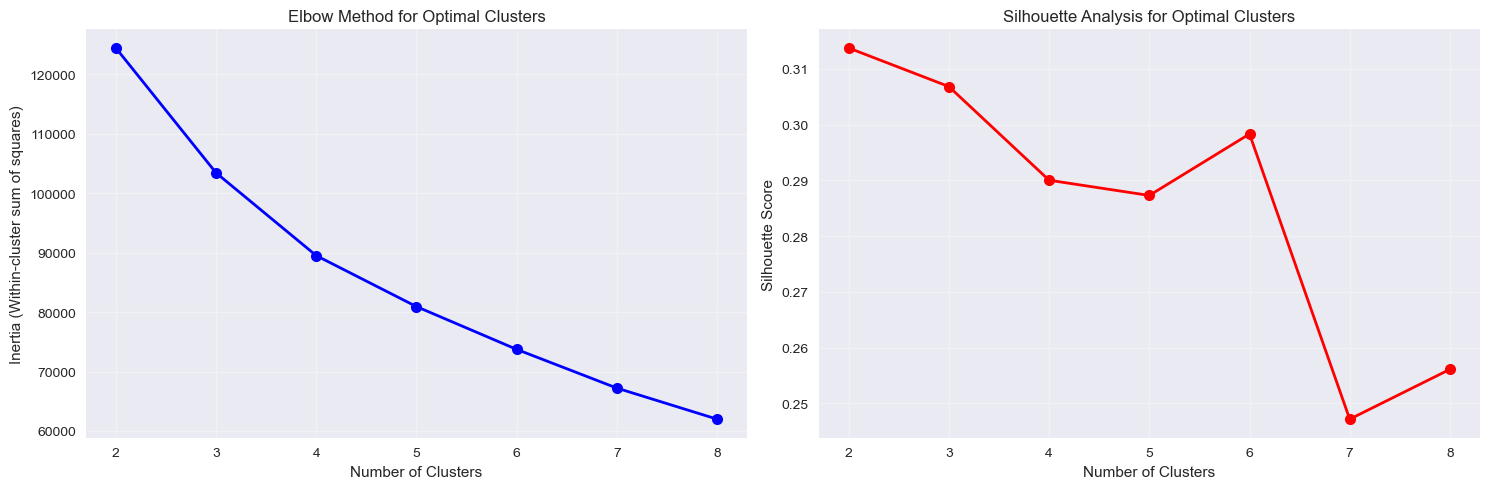


🎯 CLUSTER ANALYSIS RESULTS:
   Best silhouette score: 0.314 with 2 clusters

🏆 Top 3 cluster options:
   1. 2 clusters: silhouette = 0.314
   2. 3 clusters: silhouette = 0.307
   3. 6 clusters: silhouette = 0.298


In [33]:
# =============================================================================
# STEP 10.4: OPTIMAL NUMBER OF CLUSTERS ANALYSIS
# =============================================================================

print(f"\n🔍 STEP 10.4: DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

def find_optimal_clusters(X_scaled, max_clusters=10):
    """
    Use elbow method and silhouette analysis to find optimal number of clusters
    """
    print(f"🔍 Testing cluster numbers from 2 to {max_clusters}...")
    
    # Store results
    cluster_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    
    # Test different numbers of clusters
    for n_clusters in cluster_range:
        print(f"   Testing {n_clusters} clusters...", end=" ")
        
        # Fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        
        inertias.append(inertia)
        silhouette_scores.append(silhouette_avg)
        
        print(f"Inertia: {inertia:.0f}, Silhouette: {silhouette_avg:.3f}")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow plot
    ax1.plot(cluster_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method for Optimal Clusters')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette plot
    ax2.plot(cluster_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis for Optimal Clusters')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Recommend optimal number
    best_silhouette_idx = np.argmax(silhouette_scores)
    optimal_clusters = cluster_range[best_silhouette_idx]
    
    print(f"\n🎯 CLUSTER ANALYSIS RESULTS:")
    print(f"   Best silhouette score: {max(silhouette_scores):.3f} with {optimal_clusters} clusters")
    
    # Show top 3 options
    sorted_indices = np.argsort(silhouette_scores)[::-1]
    print(f"\n🏆 Top 3 cluster options:")
    for i, idx in enumerate(sorted_indices[:3], 1):
        n_clust = cluster_range[idx]
        score = silhouette_scores[idx]
        print(f"   {i}. {n_clust} clusters: silhouette = {score:.3f}")
    
    return optimal_clusters, inertias, silhouette_scores

# Find optimal number of clusters
optimal_k, inertias, silhouette_scores = find_optimal_clusters(X_scaled, max_clusters=8)

In [34]:
# =============================================================================
# STEP 10.5: APPLY KMEANS CLUSTERING
# =============================================================================

print(f"\n🎯 STEP 10.5: APPLYING KMEANS CLUSTERING")
print("="*60)

def apply_kmeans_clustering(X_scaled, n_clusters, feature_names):
    """
    Apply KMeans clustering with optimal number of clusters
    """
    print(f"🔧 Applying KMeans with {n_clusters} clusters...")
    
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate final metrics
    final_inertia = kmeans.inertia_
    final_silhouette = silhouette_score(X_scaled, cluster_labels)
    
    print(f"   ✅ Clustering completed!")
    print(f"   📊 Final inertia: {final_inertia:.0f}")
    print(f"   📈 Final silhouette score: {final_silhouette:.3f}")
    
    # Cluster distribution
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"\n📊 Cluster distribution:")
    for cluster, count in zip(unique, counts):
        percentage = (count / len(cluster_labels)) * 100
        print(f"   Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")
    
    # Get cluster centers in original scale
    cluster_centers_scaled = kmeans.cluster_centers_
    
    print(f"\n🎯 Cluster centers (scaled):")
    centers_df = pd.DataFrame(cluster_centers_scaled, 
                             columns=feature_names,
                             index=[f'Cluster_{i}' for i in range(n_clusters)])
    print(centers_df.round(2))
    
    return cluster_labels, kmeans, centers_df

# Apply KMeans clustering
cluster_labels, kmeans_model, cluster_centers = apply_kmeans_clustering(
    X_scaled, optimal_k, clustering_features
)

# Add cluster labels to the dataset
df_customer_final['customer_segment'] = cluster_labels

print(f"\n✅ Customer segments added to df_customer_final!")
print(f"📊 New column: 'customer_segment' with {optimal_k} segments")


🎯 STEP 10.5: APPLYING KMEANS CLUSTERING
🔧 Applying KMeans with 2 clusters...
   ✅ Clustering completed!
   📊 Final inertia: 124458
   📈 Final silhouette score: 0.314

📊 Cluster distribution:
   Cluster 0: 4,583 customers (30.6%)
   Cluster 1: 10,417 customers (69.4%)

🎯 Cluster centers (scaled):
           edad  total_payment_to_income_ratio  debt_to_income_ratio  \
Cluster_0 -0.20                           0.84                  1.05   
Cluster_1  0.09                          -0.37                 -0.46   

           payment_to_income_ratio  num_products  product_diversity  \
Cluster_0                     0.62          0.46               0.46   
Cluster_1                    -0.27         -0.20              -0.20   

           relationship_tenure_years  saldo  monto_letra  high_value_customer  \
Cluster_0                      -0.35   1.02         0.88                 1.25   
Cluster_1                       0.15  -0.45        -0.39                -0.55   

           is_retired  
Clu

In [35]:
# =============================================================================
# STEP 10.6: CLUSTER ANALYSIS AND INTERPRETATION
# =============================================================================

print(f"\n🔍 STEP 10.6: CLUSTER ANALYSIS AND INTERPRETATION")
print("="*60)

def analyze_customer_segments(df, cluster_col='customer_segment'):
    """
    Analyze and interpret customer segments
    """
    print("🔍 Analyzing customer segments...")
    
    # Basic segment statistics
    segment_stats = df.groupby(cluster_col).agg({
        'edad': ['mean', 'std'],
        'ingresos_reportados': ['mean', 'median', 'std', 'count'],
        'total_payment_to_income_ratio': ['mean', 'std'],
        'debt_to_income_ratio': ['mean', 'std'],
        'num_products': ['mean', 'std'],
        'relationship_tenure_years': ['mean', 'std'],
        'saldo': ['mean', 'median'],
        'high_value_customer': 'mean'
    }).round(2)
    
    print(f"\n📊 SEGMENT STATISTICS:")
    print(segment_stats)
    
    # Segment interpretation
    print(f"\n🎯 SEGMENT INTERPRETATION:")
    
    for segment in sorted(df[cluster_col].unique()):
        segment_data = df[df[cluster_col] == segment]
        
        avg_age = segment_data['edad'].mean()
        avg_income = segment_data['ingresos_reportados'].mean()
        avg_products = segment_data['num_products'].mean()
        avg_tenure = segment_data['relationship_tenure_years'].mean()
        high_value_pct = segment_data['high_value_customer'].mean() * 100
        retired_pct = segment_data['is_retired'].mean() * 100 if 'is_retired' in segment_data.columns else 0
        
        print(f"\n   🏷️  SEGMENT {segment} ({len(segment_data):,} customers):")
        print(f"      👥 Average age: {avg_age:.1f} years")
        print(f"      💰 Average income: ${avg_income:,.0f}")
        print(f"      🏦 Average products: {avg_products:.1f}")
        print(f"      📅 Average tenure: {avg_tenure:.1f} years")
        print(f"      💎 High-value customers: {high_value_pct:.1f}%")
        if retired_pct > 0:
            print(f"      👴 Retired customers: {retired_pct:.1f}%")
        
        # Suggest segment name based on characteristics
        if avg_age > 60 and retired_pct > 50:
            segment_name = "Senior/Retired Customers"
        elif avg_income > 150000 and high_value_pct > 50:
            segment_name = "High-Value Customers"
        elif avg_age < 35 and avg_products < 1.5:
            segment_name = "Young/Entry-Level Customers"
        elif avg_products > 1.5 and avg_tenure > 10:
            segment_name = "Established Long-term Customers"
        else:
            segment_name = "Core Customer Base"
        
        print(f"      🎯 Suggested name: {segment_name}")
    
    return segment_stats

# Analyze segments
segment_analysis = analyze_customer_segments(df_customer_final)



🔍 STEP 10.6: CLUSTER ANALYSIS AND INTERPRETATION
🔍 Analyzing customer segments...

📊 SEGMENT STATISTICS:
                   edad        ingresos_reportados                        \
                   mean    std                mean   median          std   
customer_segment                                                           
0                 52.53  11.49             1804.12  1490.42      2009.73   
1                 55.88  11.53           194705.08  1230.00  13855832.22   

                        total_payment_to_income_ratio        \
                  count                          mean   std   
customer_segment                                              
0                  4583                          0.34  0.18   
1                 10417                          0.14  0.11   

                 debt_to_income_ratio       num_products        \
                                 mean   std         mean   std   
customer_segment                                                 


📊 STEP 10.7: VISUALIZING CUSTOMER SEGMENTS
📊 Creating segment visualizations...


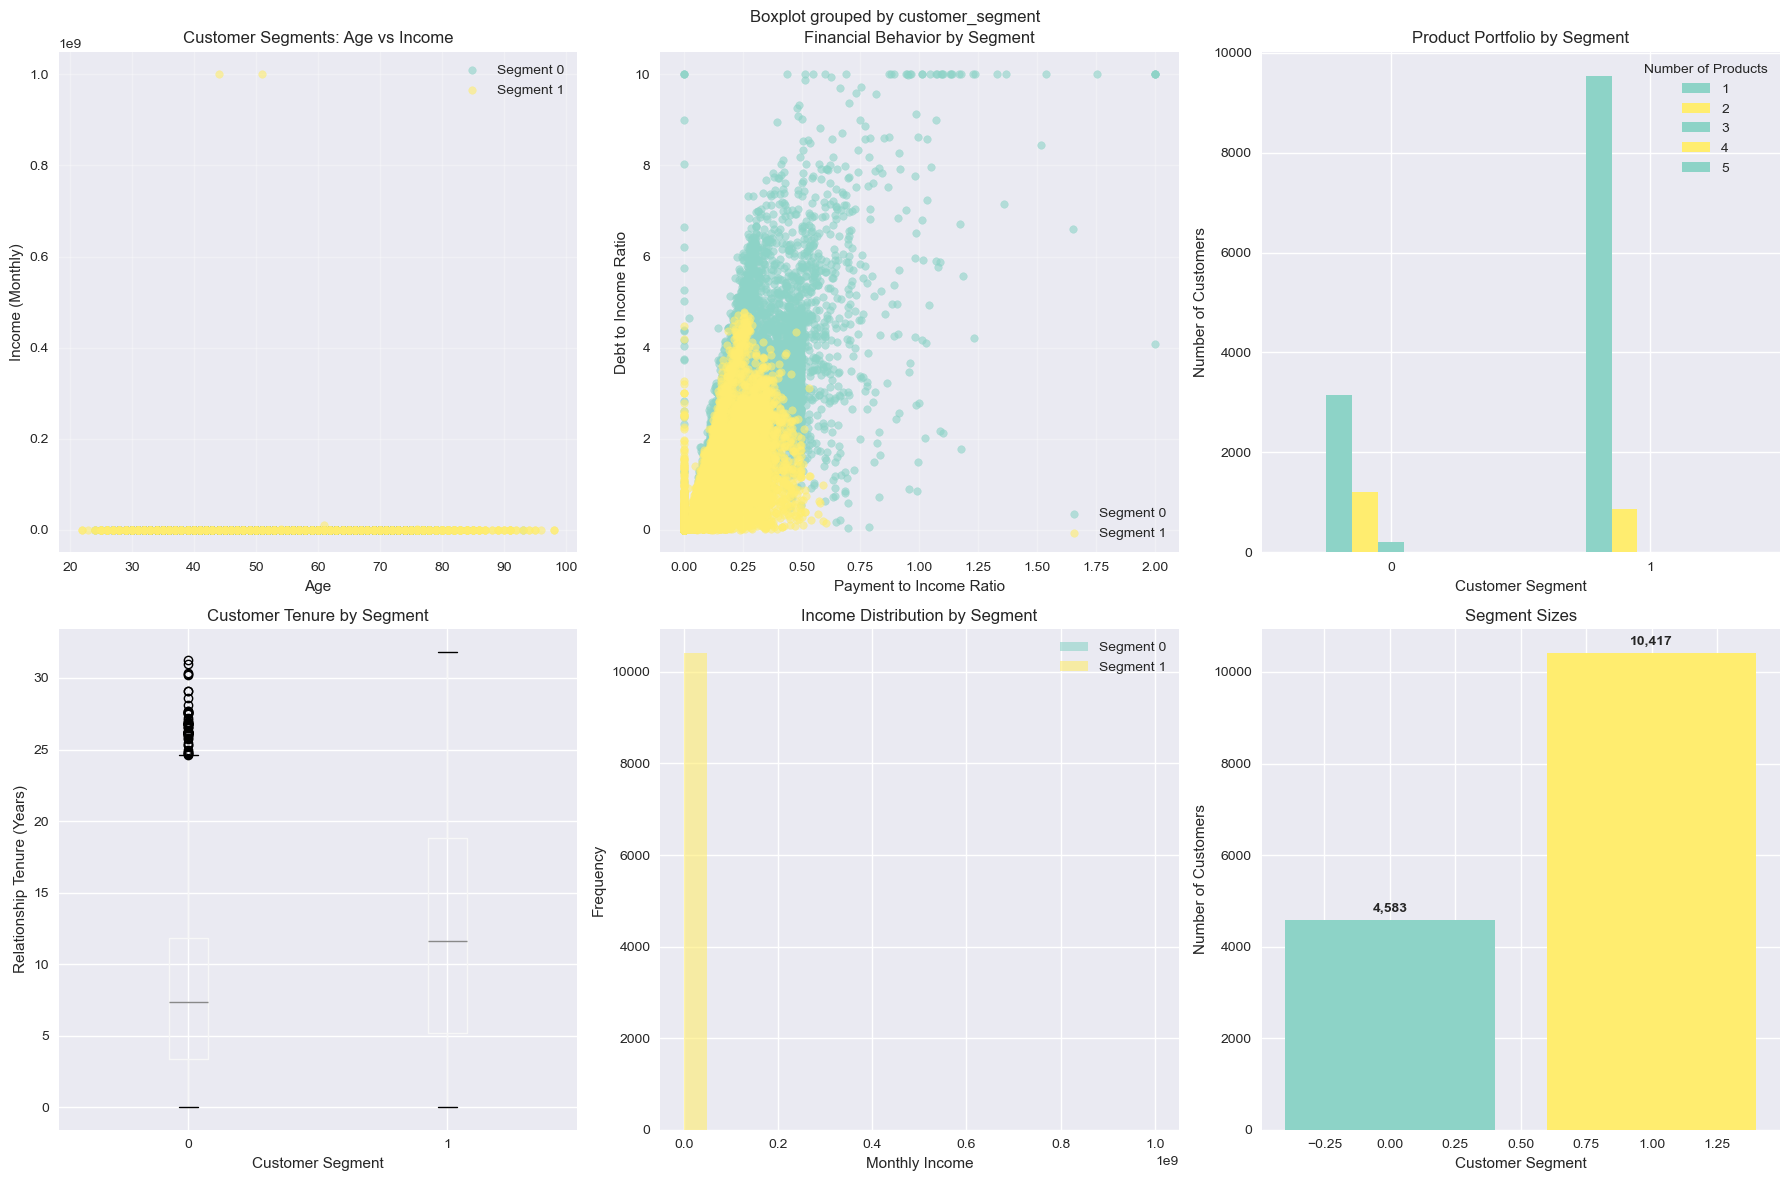

In [36]:
# =============================================================================
# STEP 10.7: VISUALIZATION OF CUSTOMER SEGMENTS
# =============================================================================

print(f"\n📊 STEP 10.7: VISUALIZING CUSTOMER SEGMENTS")
print("="*60)

def visualize_customer_segments(df, clustering_features, cluster_col='customer_segment'):
    """
    Create comprehensive visualizations of customer segments
    """
    print("📊 Creating segment visualizations...")
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    # Color palette for segments
    n_segments = df[cluster_col].nunique()
    colors = plt.cm.Set3(np.linspace(0, 1, n_segments))
    
    # Plot 1: Age vs Income by Segment
    ax = axes[0]
    for i, segment in enumerate(sorted(df[cluster_col].unique())):
        segment_data = df[df[cluster_col] == segment]
        ax.scatter(segment_data['edad'], segment_data['ingresos_reportados'], 
                  alpha=0.6, c=[colors[i]], label=f'Segment {segment}', s=30)
    
    ax.set_xlabel('Age')
    ax.set_ylabel('Income (Monthly)')
    ax.set_title('Customer Segments: Age vs Income')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Payment Ratio vs Debt Ratio
    ax = axes[1]
    for i, segment in enumerate(sorted(df[cluster_col].unique())):
        segment_data = df[df[cluster_col] == segment]
        ax.scatter(segment_data['total_payment_to_income_ratio'], 
                  segment_data['debt_to_income_ratio'],
                  alpha=0.6, c=[colors[i]], label=f'Segment {segment}', s=30)
    
    ax.set_xlabel('Payment to Income Ratio')
    ax.set_ylabel('Debt to Income Ratio')
    ax.set_title('Financial Behavior by Segment')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Number of Products Distribution
    ax = axes[2]
    segment_products = df.groupby([cluster_col, 'num_products']).size().unstack(fill_value=0)
    segment_products.plot(kind='bar', ax=ax, color=colors[:len(segment_products.columns)])
    ax.set_xlabel('Customer Segment')
    ax.set_ylabel('Number of Customers')
    ax.set_title('Product Portfolio by Segment')
    ax.legend(title='Number of Products')
    ax.tick_params(axis='x', rotation=0)
    
    # Plot 4: Relationship Tenure Distribution
    ax = axes[3]
    df.boxplot(column='relationship_tenure_years', by=cluster_col, ax=ax)
    ax.set_xlabel('Customer Segment')
    ax.set_ylabel('Relationship Tenure (Years)')
    ax.set_title('Customer Tenure by Segment')
    
    # Plot 5: Income Distribution by Segment
    ax = axes[4]
    for i, segment in enumerate(sorted(df[cluster_col].unique())):
        segment_data = df[df[cluster_col] == segment]
        ax.hist(segment_data['ingresos_reportados'], alpha=0.6, 
               label=f'Segment {segment}', bins=20, color=colors[i])
    
    ax.set_xlabel('Monthly Income')
    ax.set_ylabel('Frequency')
    ax.set_title('Income Distribution by Segment')
    ax.legend()
    
    # Plot 6: Segment Size
    ax = axes[5]
    segment_counts = df[cluster_col].value_counts().sort_index()
    bars = ax.bar(segment_counts.index, segment_counts.values, color=colors[:len(segment_counts)])
    ax.set_xlabel('Customer Segment')
    ax.set_ylabel('Number of Customers')
    ax.set_title('Segment Sizes')
    
    # Add value labels on bars
    for bar, count in zip(bars, segment_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(segment_counts)*0.01,
               f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_customer_segments(df_customer_final, clustering_features)

In [37]:
# =============================================================================
# STEP 10.8: SAVE CLUSTERING RESULTS
# =============================================================================

print(f"\n💾 STEP 10.8: SAVING CLUSTERING RESULTS")
print("="*60)

# Save clustering model and results
clustering_results = {
    'optimal_clusters': optimal_k,
    'clustering_features': clustering_features,
    'feature_categories': feature_categories,
    'silhouette_score': silhouette_score(X_scaled, cluster_labels),
    'cluster_centers': cluster_centers,
    'segment_analysis': segment_analysis
}

print(f"✅ CUSTOMER SEGMENTATION COMPLETED!")
print(f"📊 Results summary:")
print(f"   • {optimal_k} customer segments created")
print(f"   • {len(clustering_features)} features used for clustering")
print(f"   • Silhouette score: {clustering_results['silhouette_score']:.3f}")
print(f"   • Dataset enhanced with 'customer_segment' column")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Train segment-specific income prediction models")
print(f"   2. Compare performance vs global model")
print(f"   3. Implement ensemble prediction strategy")
print(f"   4. Validate business interpretability of segments")

print(f"\n💾 CLUSTERING RESULTS STORED IN 'clustering_results' VARIABLE")
print(f"📊 ENHANCED DATASET: df_customer_final (now with customer_segment column)")


💾 STEP 10.8: SAVING CLUSTERING RESULTS
✅ CUSTOMER SEGMENTATION COMPLETED!
📊 Results summary:
   • 2 customer segments created
   • 11 features used for clustering
   • Silhouette score: 0.314
   • Dataset enhanced with 'customer_segment' column

🎯 NEXT STEPS:
   1. Train segment-specific income prediction models
   2. Compare performance vs global model
   3. Implement ensemble prediction strategy
   4. Validate business interpretability of segments

💾 CLUSTERING RESULTS STORED IN 'clustering_results' VARIABLE
📊 ENHANCED DATASET: df_customer_final (now with customer_segment column)


In [38]:
df_customer_final.edad.describe() 

count    15000.000000
mean        54.854400
std         11.618029
min         22.000000
25%         47.000000
50%         54.000000
75%         63.000000
max         98.000000
Name: edad, dtype: float64

🔍 ANALYZING AGE DISTRIBUTION IN CUSTOMER BASE
📊 Overall Age Distribution:
   Mean age: 54.9 years
   Median age: 54.0 years
   Min age: 22 years
   Max age: 98 years

📈 Age Bracket Distribution:
   18-25: 22 customers (0.1%)
   26-35: 832 customers (5.5%)
   36-45: 2,321 customers (15.5%)
   46-55: 4,824 customers (32.2%)
   56-65: 4,072 customers (27.1%)
   65+: 2,929 customers (19.5%)

👥 Young Professionals (≤35 years):
   Count: 854 (5.7%)
   Average income: $1,365
   Average products: 1.17
   Average tenure: 4.3 years

👴 Retirement Age Analysis:
   Customers ≥60 years: 5,264 (35.1%)
   Explicitly retired: 3,883 (25.9%)

🏷️  Age by Customer Segment:
   Segment 0:
     Mean age: 52.5 years
     Age range: 24 - 93 years
     Young customers (≤35): 411 (9.0%)
   Segment 1:
     Mean age: 55.9 years
     Age range: 22 - 98 years
     Young customers (≤35): 443 (4.3%)


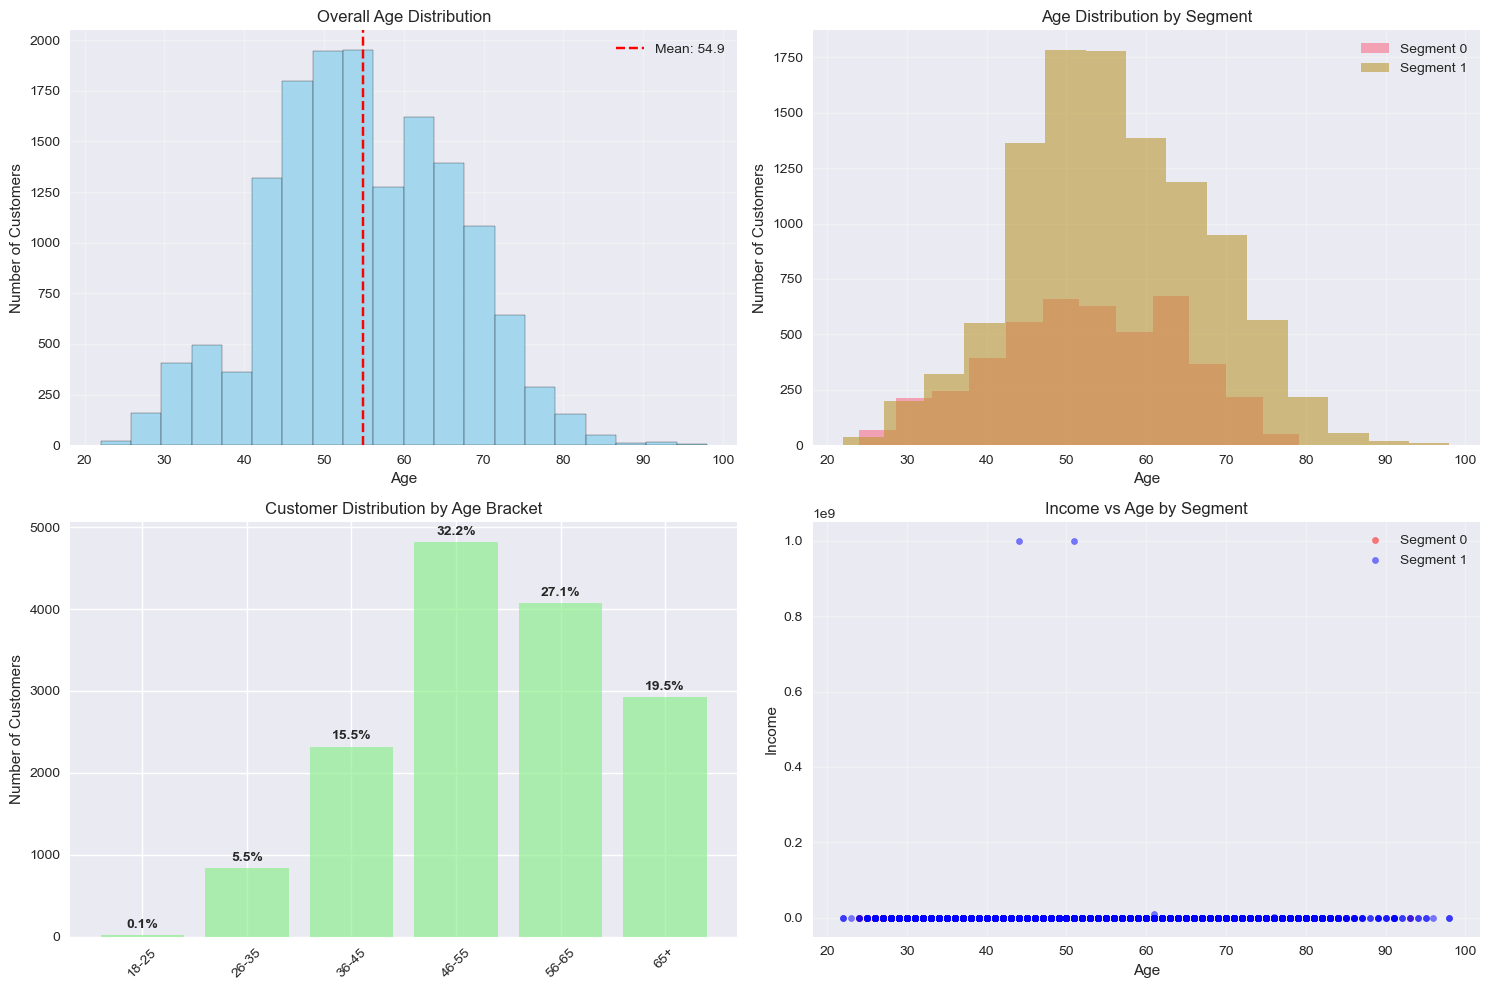

In [39]:
# =============================================================================
# AGE DISTRIBUTION ANALYSIS
# =============================================================================

print("🔍 ANALYZING AGE DISTRIBUTION IN CUSTOMER BASE")
print("="*60)

def analyze_age_distribution(df):
    """
    Detailed analysis of age distribution across segments and overall
    """
    print("📊 Overall Age Distribution:")
    
    # Basic age statistics
    age_stats = df['edad'].describe()
    print(f"   Mean age: {age_stats['mean']:.1f} years")
    print(f"   Median age: {age_stats['50%']:.1f} years")
    print(f"   Min age: {age_stats['min']:.0f} years")
    print(f"   Max age: {age_stats['max']:.0f} years")
    
    # Age brackets
    age_brackets = pd.cut(df['edad'], 
                         bins=[0, 25, 35, 45, 55, 65, 100], 
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    age_distribution = age_brackets.value_counts().sort_index()
    
    print(f"\n📈 Age Bracket Distribution:")
    for bracket, count in age_distribution.items():
        pct = (count / len(df)) * 100
        print(f"   {bracket}: {count:,} customers ({pct:.1f}%)")
    
    # Young professionals analysis
    young_professionals = df[df['edad'] <= 35]
    print(f"\n👥 Young Professionals (≤35 years):")
    print(f"   Count: {len(young_professionals):,} ({len(young_professionals)/len(df)*100:.1f}%)")
    
    if len(young_professionals) > 0:
        print(f"   Average income: ${young_professionals['ingresos_reportados'].mean():,.0f}")
        print(f"   Average products: {young_professionals['num_products'].mean():.2f}")
        print(f"   Average tenure: {young_professionals['relationship_tenure_years'].mean():.1f} years")
    
    # Retirement analysis
    retirement_age = df[df['edad'] >= 60]
    retired_customers = df[df['is_retired'] == 1] if 'is_retired' in df.columns else pd.DataFrame()
    
    print(f"\n👴 Retirement Age Analysis:")
    print(f"   Customers ≥60 years: {len(retirement_age):,} ({len(retirement_age)/len(df)*100:.1f}%)")
    if len(retired_customers) > 0:
        print(f"   Explicitly retired: {len(retired_customers):,} ({len(retired_customers)/len(df)*100:.1f}%)")
    
    # Segment-specific age analysis
    print(f"\n🏷️  Age by Customer Segment:")
    for segment in sorted(df['customer_segment'].unique()):
        segment_data = df[df['customer_segment'] == segment]
        segment_ages = segment_data['edad']
        
        print(f"   Segment {segment}:")
        print(f"     Mean age: {segment_ages.mean():.1f} years")
        print(f"     Age range: {segment_ages.min():.0f} - {segment_ages.max():.0f} years")
        
        # Young customers in this segment
        young_in_segment = segment_data[segment_data['edad'] <= 35]
        print(f"     Young customers (≤35): {len(young_in_segment):,} ({len(young_in_segment)/len(segment_data)*100:.1f}%)")
    
    return age_distribution, young_professionals

# Run age analysis
age_dist, young_prof = analyze_age_distribution(df_customer_final)

# Visualize age distribution
plt.figure(figsize=(15, 10))

# Overall age distribution
plt.subplot(2, 2, 1)
plt.hist(df_customer_final['edad'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_customer_final['edad'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df_customer_final["edad"].mean():.1f}')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Overall Age Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Age by segment
plt.subplot(2, 2, 2)
for segment in sorted(df_customer_final['customer_segment'].unique()):
    segment_data = df_customer_final[df_customer_final['customer_segment'] == segment]
    plt.hist(segment_data['edad'], alpha=0.6, label=f'Segment {segment}', bins=15)

plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Age Distribution by Segment')
plt.legend()
plt.grid(True, alpha=0.3)

# Age brackets
plt.subplot(2, 2, 3)
age_brackets = pd.cut(df_customer_final['edad'], 
                     bins=[0, 25, 35, 45, 55, 65, 100], 
                     labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
age_dist = age_brackets.value_counts().sort_index()
bars = plt.bar(range(len(age_dist)), age_dist.values, color='lightgreen', alpha=0.7)
plt.xticks(range(len(age_dist)), age_dist.index, rotation=45)
plt.ylabel('Number of Customers')
plt.title('Customer Distribution by Age Bracket')

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, age_dist.values)):
    pct = (count / len(df_customer_final)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Income vs Age scatter
plt.subplot(2, 2, 4)
colors = ['red', 'blue']
for i, segment in enumerate(sorted(df_customer_final['customer_segment'].unique())):
    segment_data = df_customer_final[df_customer_final['customer_segment'] == segment]
    plt.scatter(segment_data['edad'], segment_data['ingresos_reportados'], 
               alpha=0.5, c=colors[i], label=f'Segment {segment}', s=20)

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Income vs Age by Segment')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

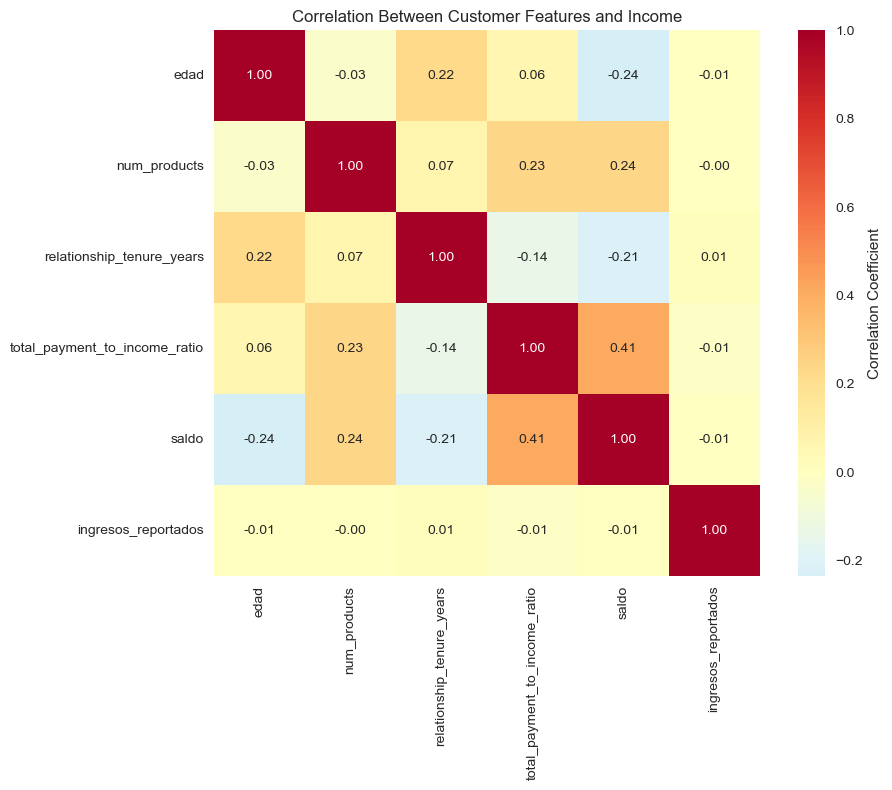

In [40]:
# Code to create this chart:
correlation_features = ['edad', 'num_products', 'relationship_tenure_years', 
                       'total_payment_to_income_ratio', 'saldo', 'ingresos_reportados']
corr_matrix = df_customer_final[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Between Customer Features and Income')
plt.tight_layout()
plt.show()

In [41]:
df_customer_final.head(5)

,identificador_unico,cliente,segmento,edad,sexo,ciudad,pais,ocupacion,estado_civil,fechaingresoempleo,nombreempleadorcliente,cargoempleocliente,productos_activos,letras_mensuales,monto_letra,saldo,fecha_inicio,fecha_vencimiento,ingresos_reportados,ocupacion_consolidated,ciudad_consolidated,nombreempleadorcliente_consolidated,cargoempleocliente_consolidated,sexo_consolidated,estado_civil_consolidated,pais_consolidated,missing_fechaingresoempleo,missing_nombreempleadorcliente,missing_cargoempleocliente,is_retired,age_group,payment_to_income_ratio,num_products,total_payment_to_income_ratio,debt_to_income_ratio,relationship_tenure_years,product_diversity,high_value_customer,customer_segment
0,1-10-156,566051,D71Z,84,Femenino,PANAMA,PANAMA,JUBILADO,Casado,1998-05-26,NO APLICA,JUBILADA,TC,1,0.0,1048.03,2011-08-25,NaT,723.42,Jubilado,Panama,No Aplica,Others,Femenino,Casado,PANAMA,0,0,0,1,65+,0.000000,1,0.000000,0.120726,14.023272,1,0,1
1,1-11-534,886462,D73Z,79,Femenino,PANAMA,PANAMA,JUBILADO,Casado,2002-12-09,NO APLICA,JUBILADO,20AH|TC,2,157.0,2466.44,2017-12-13,2026-11-06,979.06,Jubilado,Panama,No Aplica,Jubilado,Femenino,Casado,PANAMA,0,0,0,1,65+,0.080179,2,0.160358,0.209933,7.720739,2,0,1
2,1-11-601,498907,D45Z,81,Femenino,CHANGUINOLA,PANAMA,JUBILADO,Casado,2001-04-27,NO APLICA,NaN,TC,1,0.0,64.34,2008-04-22,NaT,555.34,Jubilado,Others,No Aplica,Others,Femenino,Casado,PANAMA,0,0,1,1,65+,0.000000,1,0.000000,0.009655,17.363450,1,0,1
3,1-11-794,638066,B45D,78,Femenino,ALMIRANTE,PANAMA,JUBILADO,Casado,2003-11-10,NO APLICA,NaN,20AH,1,64.0,435.26,2025-03-20,2026-03-20,1500.00,Jubilado,Others,No Aplica,Others,Femenino,Casado,PANAMA,0,0,1,1,65+,0.042667,1,0.042667,0.024181,0.454483,1,0,1
4,1-12-827,788221,D45Z,75,Femenino,CHANGUINOLA,PANAMA,JUBILADO,Soltero,2007-07-06,NO APLICA,AUX. ENFERMERIA,TC,1,0.0,3.81,1998-11-20,NaT,767.04,Jubilado,Others,No Aplica,Others,Femenino,Soltero,PANAMA,0,0,0,1,65+,0.000000,1,0.000000,0.000414,26.784394,1,0,1


In [42]:
#final data to csv
df_customer_final.to_csv('../data/processed/final_dataset.csv', index=False)